# Ptf Replica

In [327]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Suppress FutureWarnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Load the dataset from an Excel file
path = 'Dataset3_PortfolioReplicaStrategyErrataCorrige.xlsx' # Dataset

# SET EDA_FLAG TRUE to perform exploratory data analysis
EDA_flag = False

# Set the number of trials for the optimization process, if 0 the model run on the trained data
n_trials = 0

In [328]:
import ipywidgets as widgets
from IPython.display import display

# read the name of the selected portfolio
def get_selected_portfolio():
    selected_value = portfolio_selector.value
    if selected_value == 1:
        return "Portfolio Equity"
    elif selected_value == 2:
        return "Portfolio Bond"
    elif selected_value == 3:
        return "Portfolio LifeStrategy 80_20"
    elif selected_value == 0:
        return "NOT A CHOICE"
    else:
        return None

# 2) create a small dropdown or radio‐button selector
opt = {
    "NOT A CHOICE": 0,
    "Portfolio Equity": 1,
    "Portfolio Bond": 2,
    "Portfolio LifeStrategy 80_20": 3,
}

# 1) il selettore delle 3 opzioni
portfolio_selector = widgets.RadioButtons(
    options=[
        ("NOT A CHOICE", 0),
        ("Portfolio Equity", 1),
        ("Portfolio Bond", 2),
        ("Portfolio LifeStrategy", 3),
    ],
    description="Scegli:",
)

# 2) il bottone di conferma
submit_btn = widgets.Button(description="Conferma")

# 3) area di output per log/errori
out = widgets.Output()

# 4) la funzione che viene eseguita solo dopo il click
def on_submit(b):
    with out:
        selected_flag = portfolio_selector.value
        print(f"Hai scelto il portfolio:", get_selected_portfolio())

# 5) colleghiamo il callback
submit_btn.on_click(on_submit)

# 6) mostriamo tutto
display(portfolio_selector, submit_btn, out)

RadioButtons(description='Scegli:', options=(('NOT A CHOICE', 0), ('Portfolio Equity', 1), ('Portfolio Bond', …

Button(description='Conferma', style=ButtonStyle())

Output()

In [468]:
selected_flag = portfolio_selector.value
print("Flag salvato:", get_selected_portfolio())

if selected_flag == 0:
    # disp an error message if no portfolio is selected
    raise ValueError("Invalid portfolio selection. Please select a valid portfolio. AND RE-RUN THE THE CODE FROM THIS CELL ONWARDS.")

Flag salvato: Portfolio Equity


In [469]:
# Read the Excel file, and save the names of the assets (row 4)
full_names_df = pd.read_excel(path, header=None, skiprows=3, nrows=1)
full_names = full_names_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Read Bloomberg tickers (row 6)
tickers_df = pd.read_excel(path, header=None, skiprows=5, nrows=1)
tickers = tickers_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Create a dictionary mapping tickers to full names
variable_info = dict(zip(tickers, full_names))

# Read the actual data without using any row as a header
data_raw = pd.read_excel(path, header=None, skiprows=6)

# cut the data before the 01/01/2017 #####################################################################################################################################################
data_raw = data_raw[data_raw[0] >= '2014-01-01']  # Filter rows based on the date column

# First column is the date column
data_raw.columns = ['Date'] + tickers  # Assign the columns correctly using tickers

# Set the date column as the index and ensure it's in datetime format
data_raw['Date'] = pd.to_datetime(data_raw['Date'], format='%d/%m/%Y')
data = data_raw.set_index('Date')

# cCreate a dictionary to hold the index components based on the selected portfolio, and a DataFrame to hold the target data
if selected_flag == 1: # Portfolio Equity
    # EQUITY ETF
    index_components = {
        'MXWO Index': 1
    }
    df_target = data[['MXWO Index']].copy()  # Select the 'MXWO Index' column for further processing

    # VaR parameters - in the equity case, we assume a higher risk profile
    var_confidence = 0.01  # 1% VaR
    var_horizon = 4  # 4 weeks (1 month)
    max_var_threshold = 0.12  # 20% maximum VaR(1%, 1 month)

elif selected_flag == 2: # Portfolio Bond
    # BOND ETF
    index_components = {
        'LEGATRUU Index': 1
    }
    df_target = data[['LEGATRUU Index']].copy()  # Select the 'LEGATRUU Index' column for further processing
    
    # VaR parameters
    var_confidence = 0.01  # 1% VaR
    var_horizon = 4  # 4 weeks (1 month)
    max_var_threshold = 0.08  # 20% maximum VaR(1%, 1 month)

elif selected_flag == 3: # Portfolio LifeStrategy 80/20
    # LIFE STRATEGY ETF
    index_components = {
        'MXWO Index': 0.5,
        'LEGATRUU Index': 0.5,
    }
    df_target = data[['MXWO Index', 'LEGATRUU Index']].copy()  # Select the 'MXWO Index' column for further processing

    # VaR parameters
    var_confidence = 0.01  # 1% VaR
    var_horizon = 4  # 4 weeks (1 month)
    max_var_threshold = 0.08  # 20% maximum VaR(1%, 1 month)
else:
    raise ValueError("Invalid portfolio selection. Please select a valid portfolio.")

# Create a DataFrame to hold the the underlyings
futures_contracts = [
    'RX1 Comdty', 'TY1 Comdty', 'GC1 Comdty', 'CO1 Comdty',
    'ES1 Comdty', 'VG1 Comdty', 'NQ1 Comdty',
    'TP1 Comdty', 'DU1 Comdty', 'TU2 Comdty'
]
df_underlyings = data[futures_contracts].copy()  # Create an empty DataFrame to hold the underlyings

# Transaction costs
transaction_cost = 0.0005  # 0.05% transaction costs
annual_factor = 52  # Number of weeks in a year, to be set following the data frequency

# Create a dictionary to hold the VaR parameters
var_parameters = {
    'var_confidence': var_confidence,
    'var_horizon': var_horizon,
    'max_var_threshold': max_var_threshold
}

In [470]:
data.head()  # Display the first few rows of the data for verification

,MXWO Index,MXWD Index,LEGATRUU Index,HFRXGL Index,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
Date,,,,,,,,,,,,,,
2014-01-07,1647.65,404.25,453.7100,1222.20,139.76,123.687500,1229.6,107.35,1830.75,3105.0,3548.75,1281.5,110.295,109.679688
2014-01-14,1651.73,405.31,456.7288,1229.85,140.68,124.171875,1245.4,106.39,1833.00,3112.0,3573.75,1271.0,110.330,109.695312
2014-01-21,1659.49,406.82,455.4600,1231.47,141.65,124.375000,1241.8,106.73,1838.50,3150.0,3609.50,1297.5,110.430,109.679688
2014-01-28,1611.35,394.65,458.5947,1222.62,142.46,125.078125,1250.8,107.41,1788.25,3033.0,3501.00,1223.0,110.520,109.765625
2014-02-04,1569.93,384.84,459.8792,1222.50,143.98,126.140625,1251.7,105.78,1743.75,2965.0,3452.00,1131.0,110.625,109.914062


In [471]:
from ReplicaClass import PortfolioReplicator

rep = PortfolioReplicator(df_target, index_components, df_underlyings, 
                          var_parameters, transaction_cost, annual_factor, name = 'Portfolio Replica Strategy')

display(pd.concat([rep._y, rep._X], axis=1).head())
display(pd.concat([rep._y, rep._X], axis=1).describe())

,MXWO Index,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
Date,,,,,,,,,,,
2014-01-07,1647.65,139.76,123.687500,1229.6,107.35,1830.75,3105.0,3548.75,1281.5,110.295,109.679688
2014-01-14,1651.73,140.68,124.171875,1245.4,106.39,1833.00,3112.0,3573.75,1271.0,110.330,109.695312
2014-01-21,1659.49,141.65,124.375000,1241.8,106.73,1838.50,3150.0,3609.50,1297.5,110.430,109.679688
2014-01-28,1611.35,142.46,125.078125,1250.8,107.41,1788.25,3033.0,3501.00,1223.0,110.520,109.765625
2014-02-04,1569.93,143.98,126.140625,1251.7,105.78,1743.75,2965.0,3452.00,1131.0,110.625,109.914062


,MXWO Index,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,1972.229738,162.680157,127.797244,1357.259318,61.566483,2545.637402,3316.876640,6518.239501,1546.080052,111.787349,108.473528
std,306.684514,8.939224,5.445043,220.709482,19.501214,550.411089,254.716743,2582.341490,188.447087,0.544652,1.494590
min,1488.540000,139.760000,117.812500,1062.900000,19.330000,1743.750000,2518.000000,3452.000000,1131.000000,110.295000,105.125000
25%,1715.820000,158.130000,124.593750,1222.300000,48.810000,2074.500000,3117.000000,4429.000000,1397.000000,111.480000,107.648438
50%,1928.740000,162.800000,126.921875,1284.000000,58.510000,2463.750000,3326.000000,5912.000000,1571.000000,111.965000,108.968750
75%,2147.670000,170.490000,130.406250,1400.500000,68.120000,2888.250000,3512.000000,7638.750000,1681.000000,112.145000,109.492188
max,2944.050000,179.320000,140.328125,2001.200000,114.460000,4132.800000,3920.000000,13975.750000,1978.000000,112.720000,110.527344


In [472]:
# EDA_flag = True -> perform exploratory data analysis
if EDA_flag:
    rep.plot_cumulative_returns()


    target_fin_stats, underlyings_fin_stats = rep.fin_stats()
    display(target_fin_stats)
    display(underlyings_fin_stats)


    rep.corr_map()


    rep.return_distribution()


    rep.plot_log_returns()


    rolling_window = 52  # 1 year rolling window
    rep.plot_rolling_correlation(window=rolling_window)


    rep.bar_corr_target_underlyings()


    rep.normality_check()


    rep.stationarity_check()
else:
    print("Exploratory Data Analysis is skipped. Set EDA_flag to True to perform EDA.")

Exploratory Data Analysis is skipped. Set EDA_flag to True to perform EDA.


# EQ


Metrics for Equally Weighted Portfolio:


,information_ratio,correlation,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
0,-0.364449,0.837136,0.096253,0.741458,1.0,NaN



Detailed metrics for Equally Weighted vs Target:


,Metric,Target,Replica
0,Annualized return,11.39%,7.88%
1,Annualized volatility,16.57%,10.63%
2,Sharpe ratio,0.69,0.74
3,Max Drawdown,28.04%,17.36%
4,Tracking Error,N/A,9.63%
5,Information ratio,N/A,-0.36
6,Correlation,N/A,0.8371
7,Average gross exposure,N/A,1.0000
8,"Average VaR (1%, 1M)",N/A,nan%


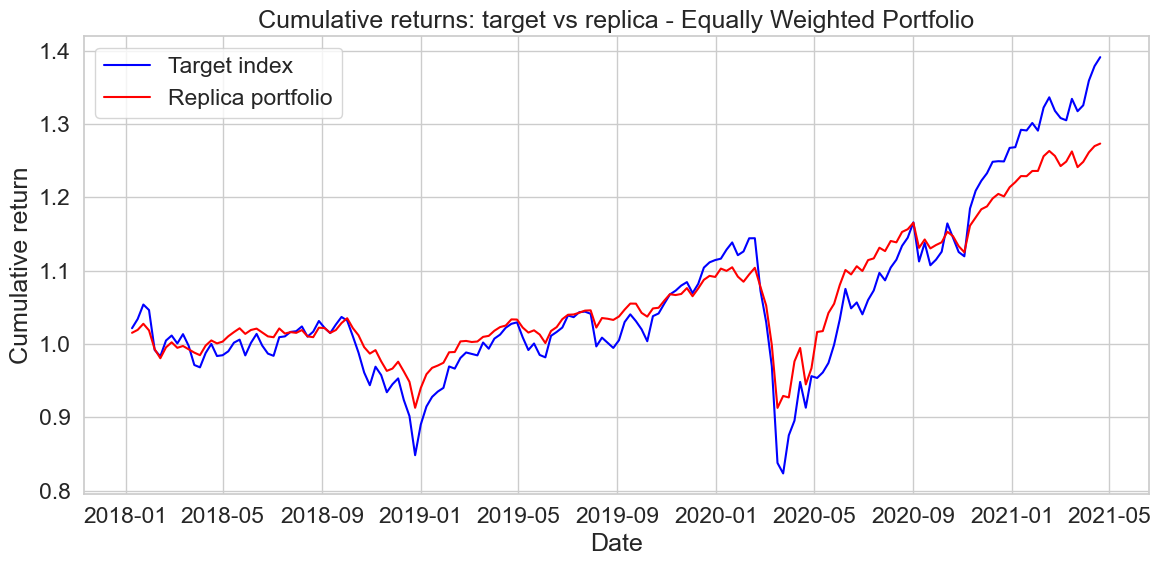

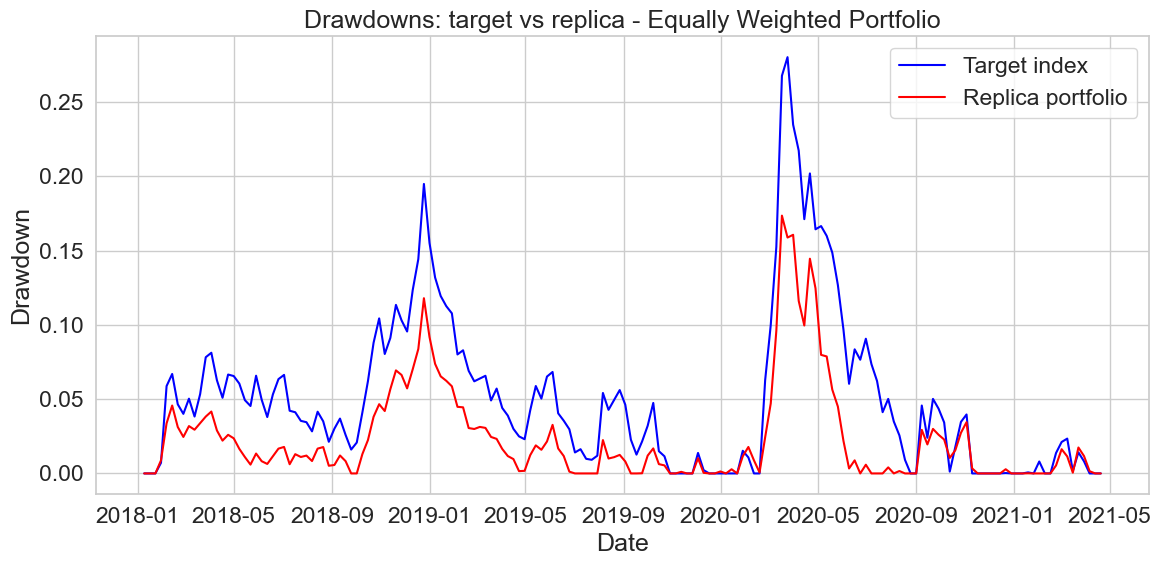

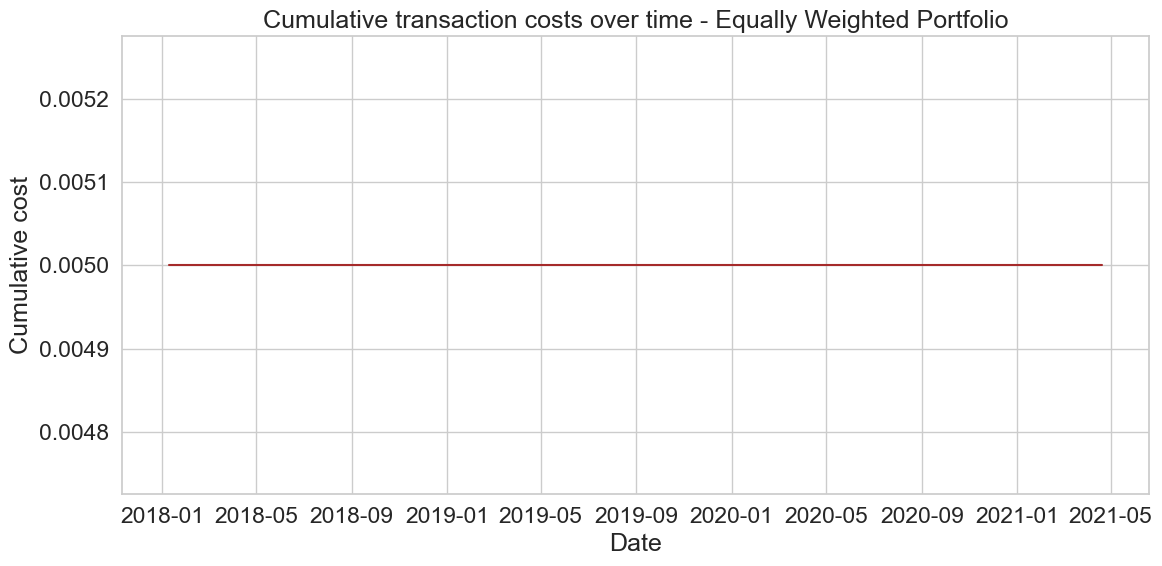

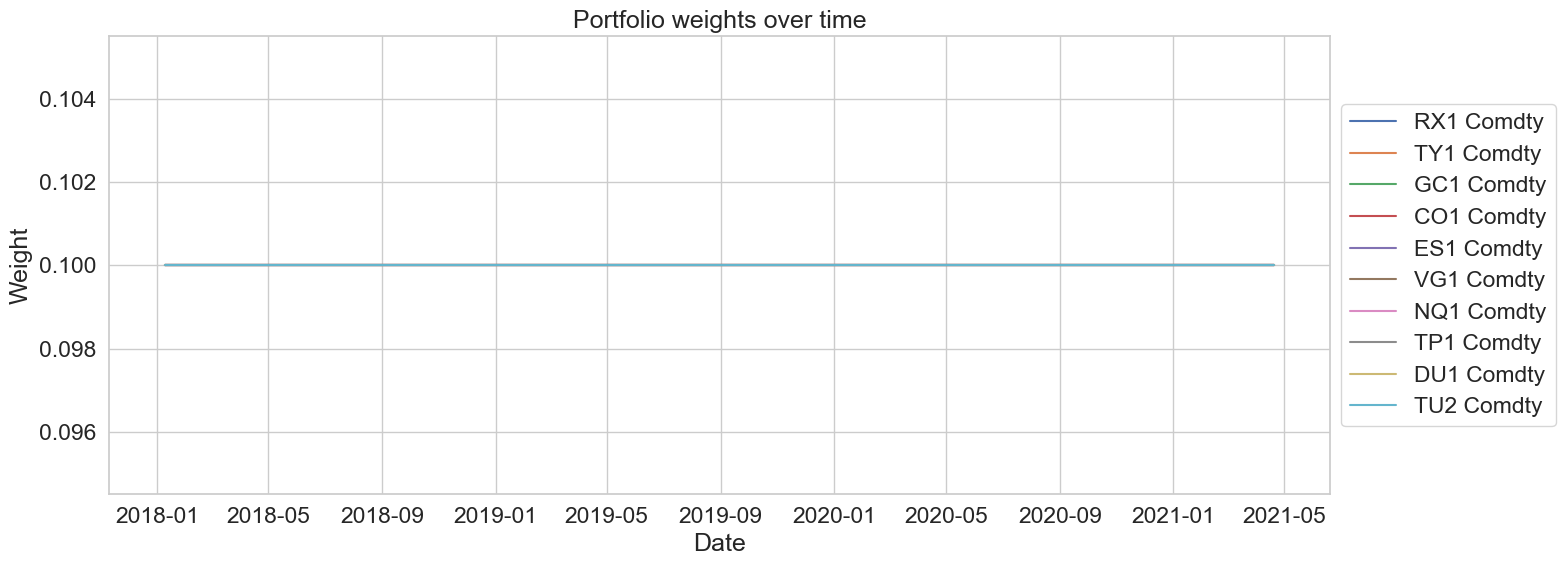

In [473]:
# Param
window = 208

results_equal_weighted = rep.run_equal_weight_portfolio(window)

# Create a DataFrame for the results
result_equal_weighted_df = pd.DataFrame([results_equal_weighted])

# Display the results
print("\nMetrics for Equally Weighted Portfolio:")
display(result_equal_weighted_df[['information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(1))
 
# Extract the first row for detailed metrics
result_equal_weighted_df = result_equal_weighted_df.iloc[0]

# Create detailed metrics table for the LR configuration
metrics_normalized_equal_weighted = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{result_equal_weighted_df['target_return']*100:.2f}%",
               f"{result_equal_weighted_df['target_vol']*100:.2f}%",
               f"{result_equal_weighted_df['target_sharpe']:.2f}",
               f"{result_equal_weighted_df['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{result_equal_weighted_df['replica_return']*100:.2f}%",
                f"{result_equal_weighted_df['replica_vol']*100:.2f}%",
                f"{result_equal_weighted_df['replica_sharpe']:.2f}",
                f"{result_equal_weighted_df['max_drawdown']*100:.2f}%",
                f"{result_equal_weighted_df['tracking_error']*100:.2f}%",
                f"{result_equal_weighted_df['information_ratio']:.2f}",
                f"{result_equal_weighted_df['correlation']:.4f}",
                f"{result_equal_weighted_df['avg_gross_exposure']:.4f}",
                f"{result_equal_weighted_df['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for Equally Weighted vs Target:")
display(metrics_normalized_equal_weighted)

# Plot the results for the Linear Regression model
rep.plot_metrics(result_equal_weighted_df, 'Equally Weighted Portfolio')

# EN

In [474]:

# 3) Run Optuna search, depending on the selected portfolio we differentiate the storage aand name of the study
name = get_selected_portfolio()
# the storage name wll be EN_PtfName and is in the foalder called with the name of the portfolio
folder_name = f"{name.replace(' ', '_')}"  # e.g., EN_Portfolio_Equity
storage_name = f"EN_{name.replace(' ', '_')}"  # e.g., optuna_Portfolio_Equity
stu_name = f"EN_{name.replace(' ', '_')}_study"  # e.g., Portfolio_Equity_study

storage_dir = Path.cwd() / folder_name
storage_dir.mkdir(parents=True, exist_ok=True)

# 2) build the full sqlite URL
storage_path = f"./{folder_name}/{storage_name}"

study_EN = rep.run_optuna_normalized(
    n_trials=n_trials,
    storage=storage_path,
    study_name=stu_name,
    obj = rep._optuna_objective_EN
)

[I 2025-05-30 01:43:34,114] Using an existing study with name 'EN_Portfolio_Equity_study' instead of creating a new one.



Top Optuna configuration by information ratio:


,l1_ratio,rolling_window,alpha,information_ratio,correlation,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
0,0.984928,156,0.010585,0.188837,0.94173,0.049863,1.064951,0.836151,0.078428



Detailed metrics for the best configuration (normalized returns):


,Metric,Target,Replica
0,Annualized return,13.08%,14.02%
1,Annualized volatility,14.69%,13.17%
2,Sharpe ratio,0.89,1.06
3,Max Drawdown,28.04%,20.14%
4,Tracking Error,N/A,4.99%
5,Information ratio,N/A,0.19
6,Correlation,N/A,0.9417
7,Average gross exposure,N/A,0.8362
8,"Average VaR (1%, 1M)",N/A,7.84%


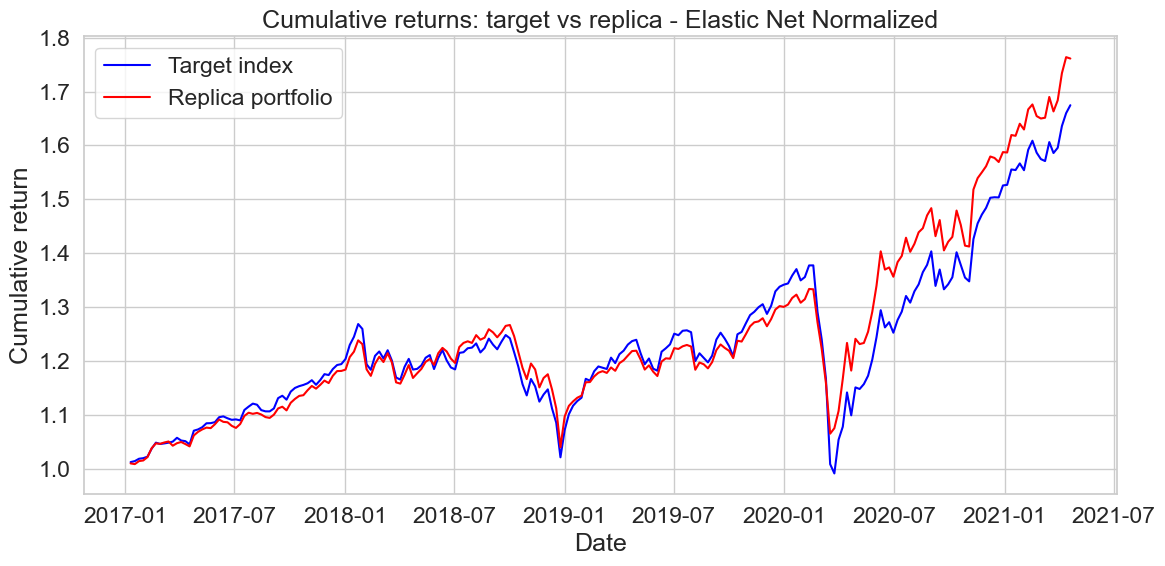

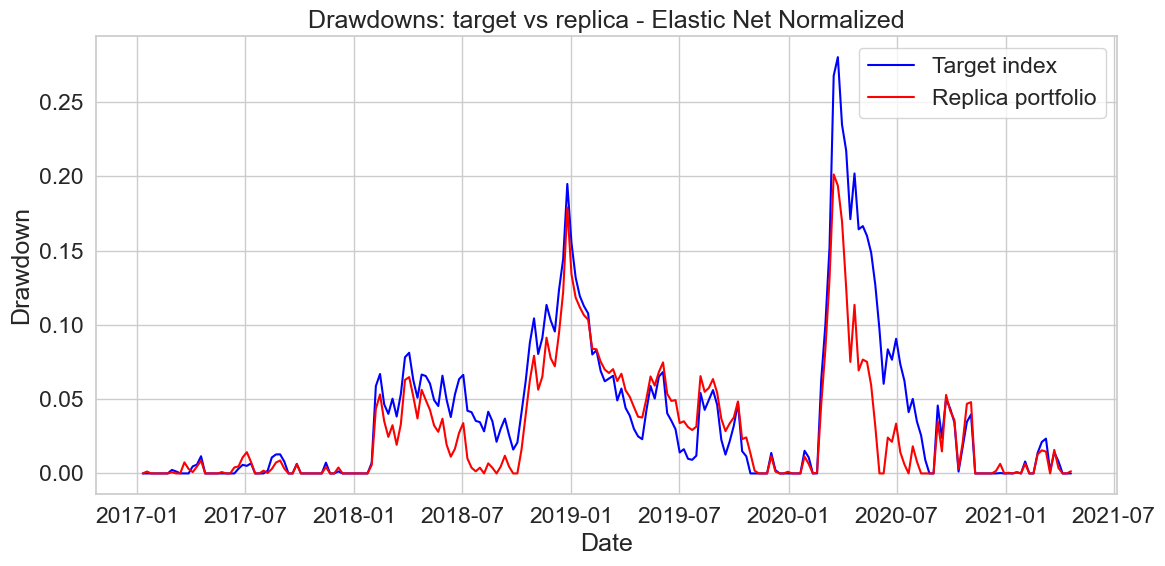

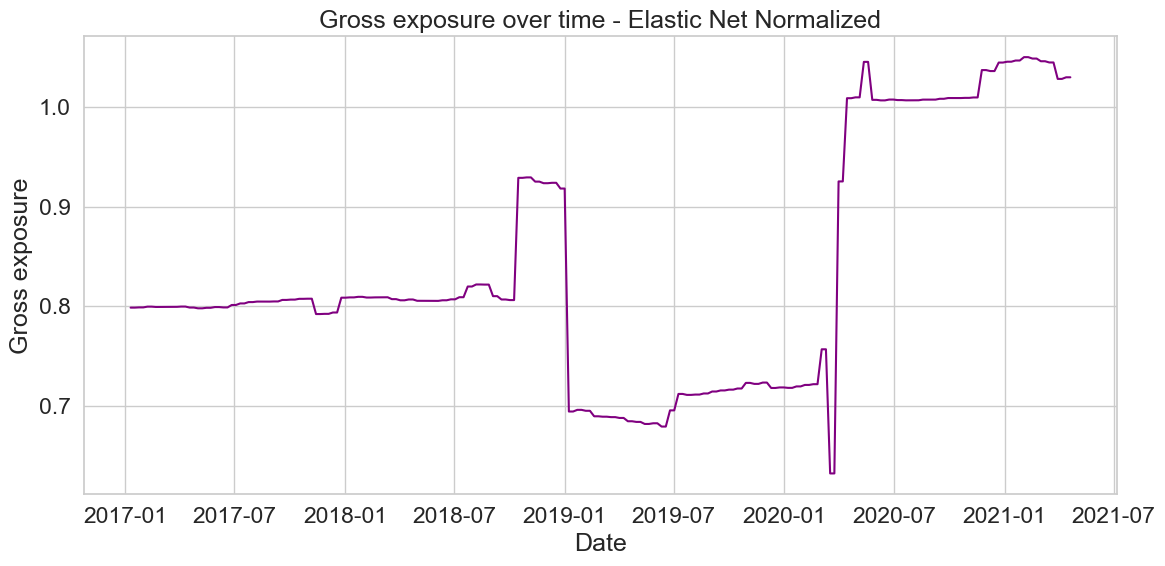

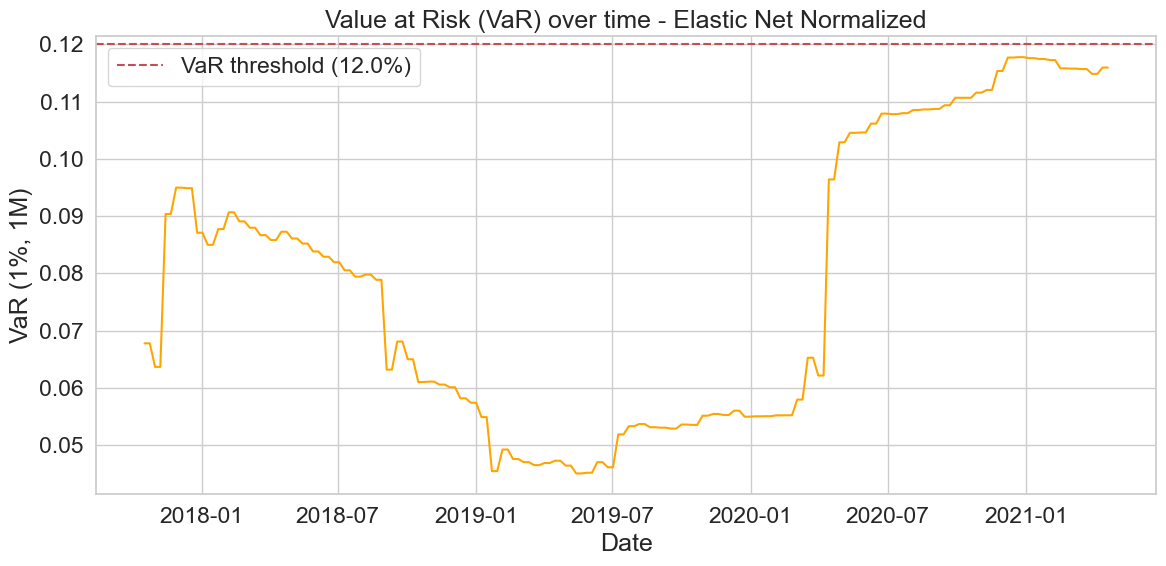

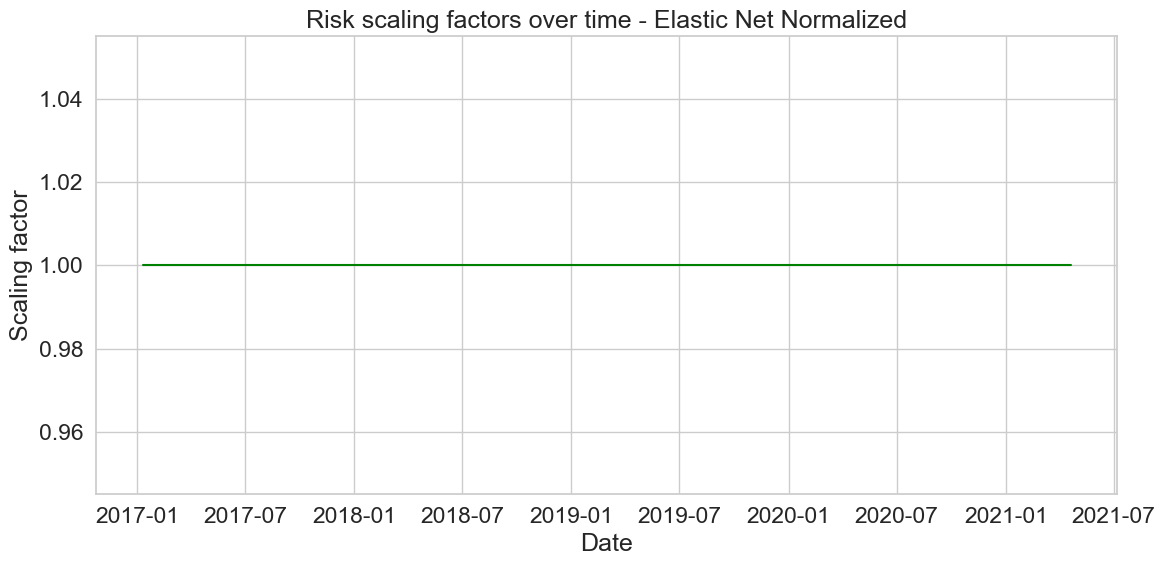

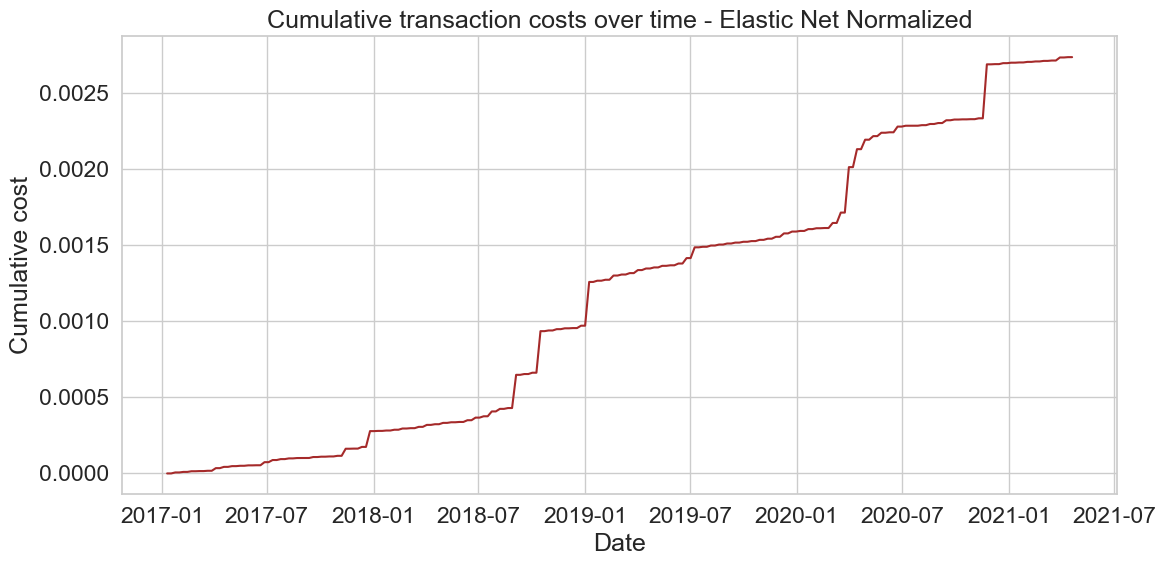

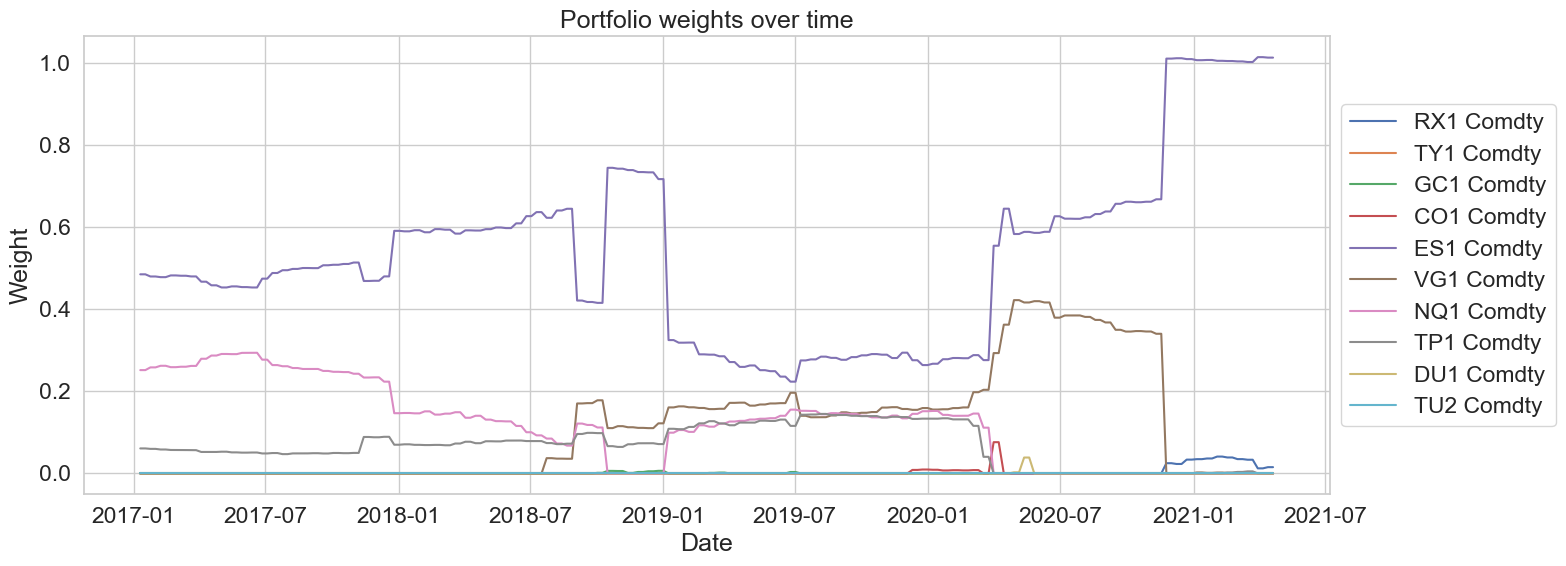

In [475]:
results_normalized_EN = []

best = study_EN.best_params
l1_ratio = best["l1_ratio"]
rolling_window = best["rolling_window"]
alpha = best["alpha"]
rebalancing_window = best["rebalancing_window"]

results_EN = rep.run_elasticnet_normalized(l1_ratio, rolling_window, alpha,rebalancing_window)
results_normalized_EN.append(results_EN)

# Convert results to DataFrame for easier analysis
results_df_normalized_EN = pd.DataFrame(results_normalized_EN)

# Display top configuration by information ratio
print("\nTop Optuna configuration by information ratio:")
display(results_df_normalized_EN[['l1_ratio', 'rolling_window', 'alpha', 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(10))

best_config_normalized_EN = results_df_normalized_EN.iloc[0]

# Create detailed metrics table for the best configuration
metrics_normalized_EN = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized_EN['target_return']*100:.2f}%",
               f"{best_config_normalized_EN['target_vol']*100:.2f}%",
               f"{best_config_normalized_EN['target_sharpe']:.2f}",
               f"{best_config_normalized_EN['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized_EN['replica_return']*100:.2f}%",
                f"{best_config_normalized_EN['replica_vol']*100:.2f}%",
                f"{best_config_normalized_EN['replica_sharpe']:.2f}",
                f"{best_config_normalized_EN['max_drawdown']*100:.2f}%",
                f"{best_config_normalized_EN['tracking_error']*100:.2f}%",
                f"{best_config_normalized_EN['information_ratio']:.2f}",
                f"{best_config_normalized_EN['correlation']:.4f}",
                f"{best_config_normalized_EN['avg_gross_exposure']:.4f}",
                f"{best_config_normalized_EN['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized_EN)

# Plot the results for the best configuration
rep.plot_metrics(best_config_normalized_EN, 'Elastic Net Normalized')

# KF


Top Optuna configuration by information ratio:


,information_ratio,correlation,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
0,-0.162031,0.949684,0.051987,0.683638,1.162389,0.096205



Detailed metrics for the best configuration (normalized returns):


,Metric,Target,Replica
0,Annualized return,11.39%,10.55%
1,Annualized volatility,16.57%,15.43%
2,Sharpe ratio,0.69,0.68
3,Max Drawdown,28.04%,22.88%
4,Tracking Error,N/A,5.20%
5,Information ratio,N/A,-0.16
6,Correlation,N/A,0.9497
7,Average gross exposure,N/A,1.1624
8,"Average VaR (1%, 1M)",N/A,9.62%


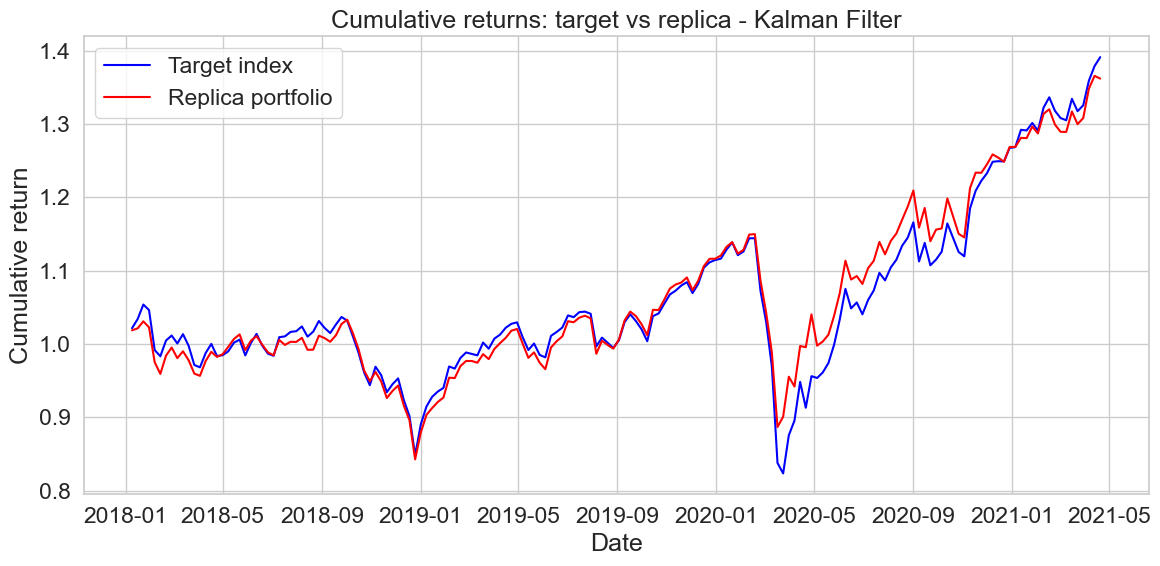

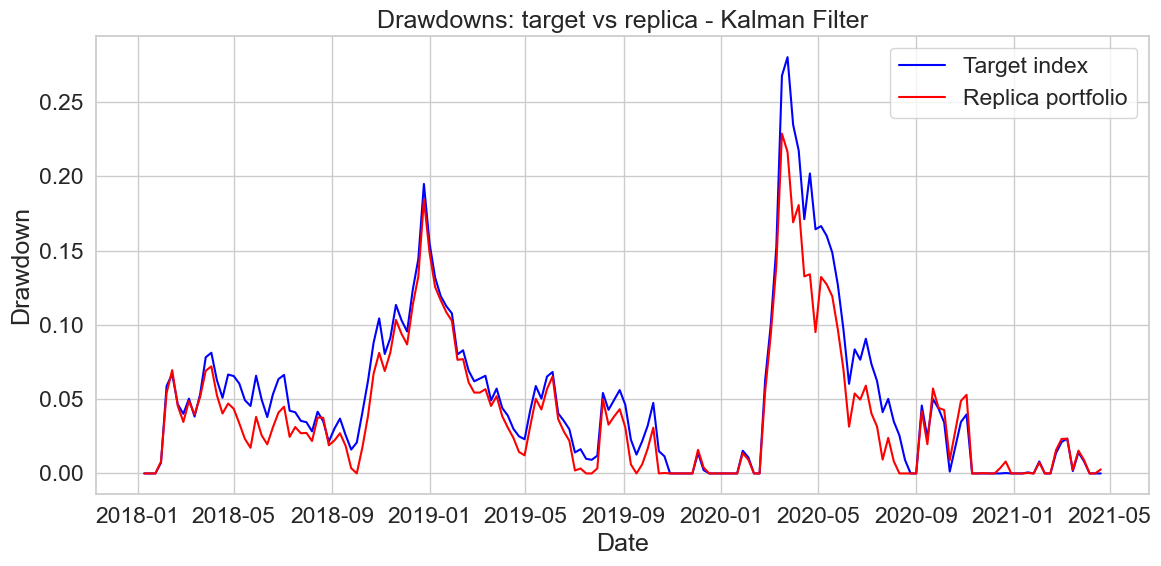

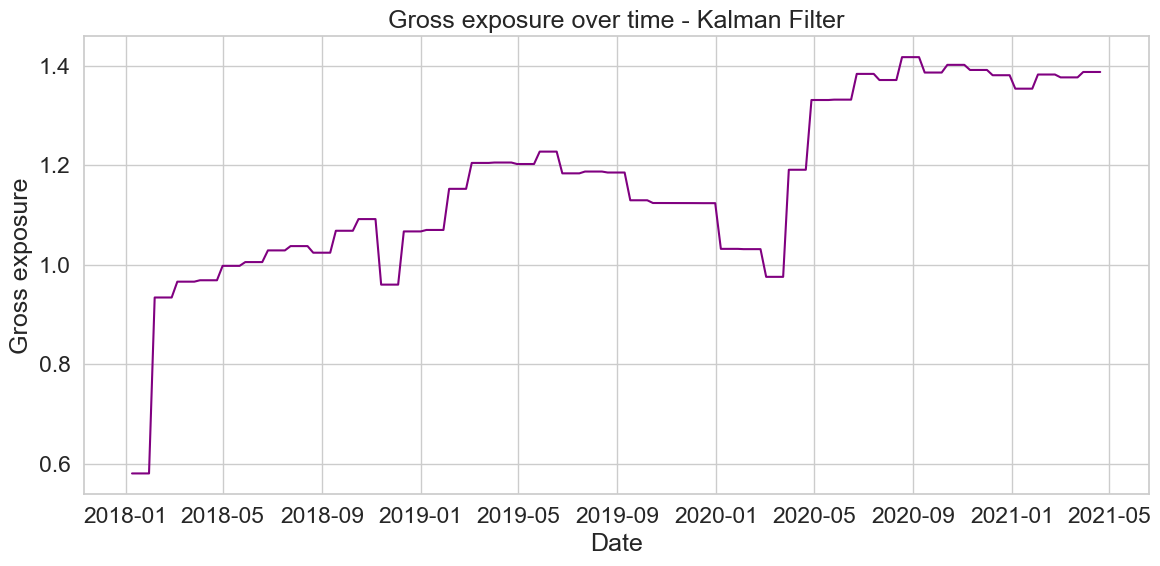

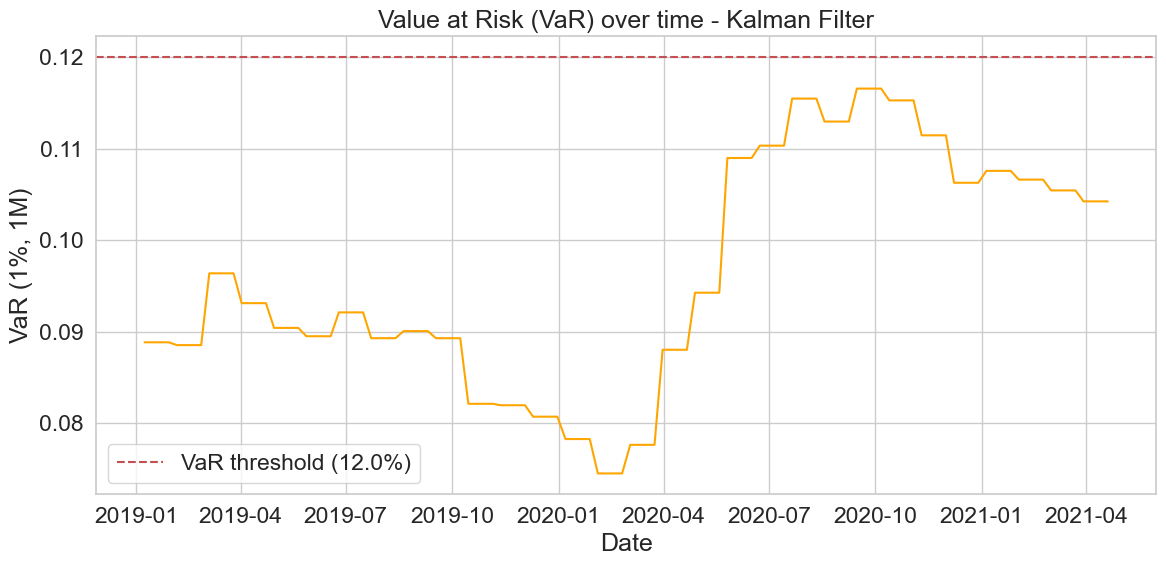

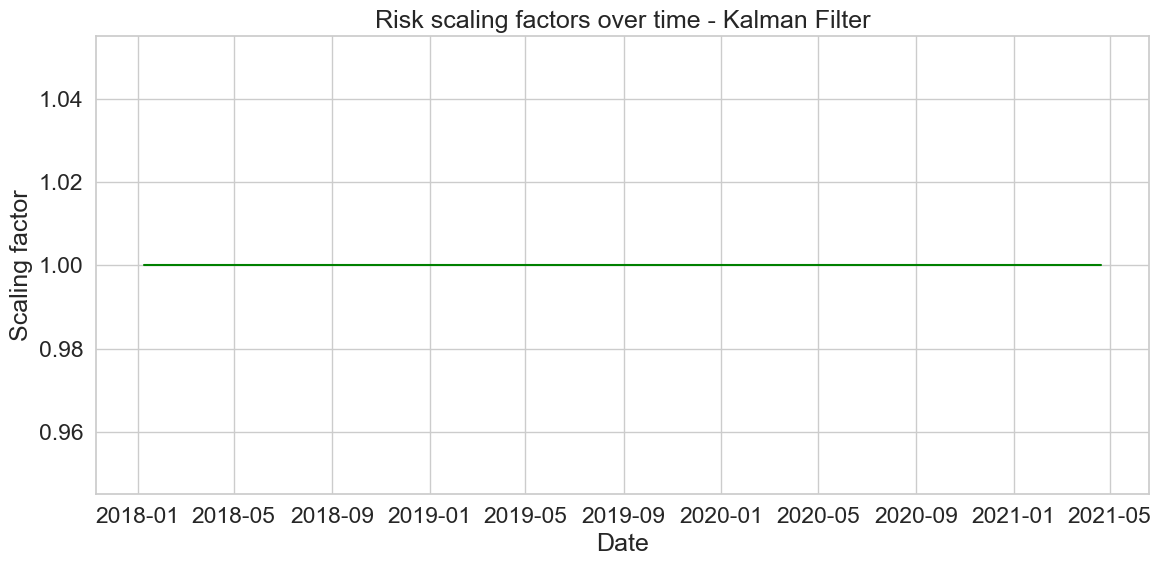

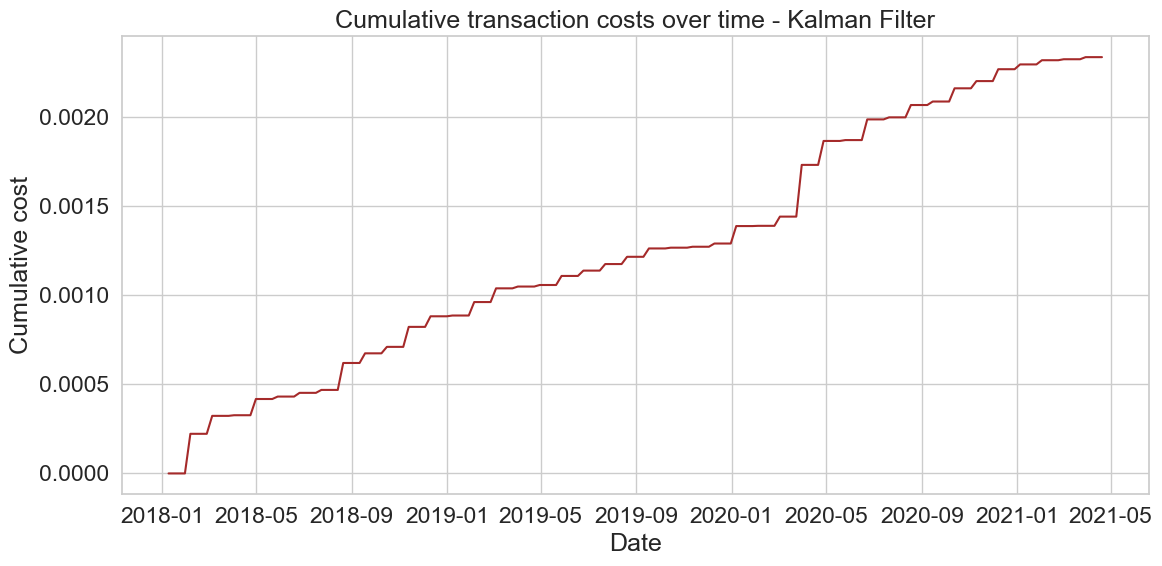

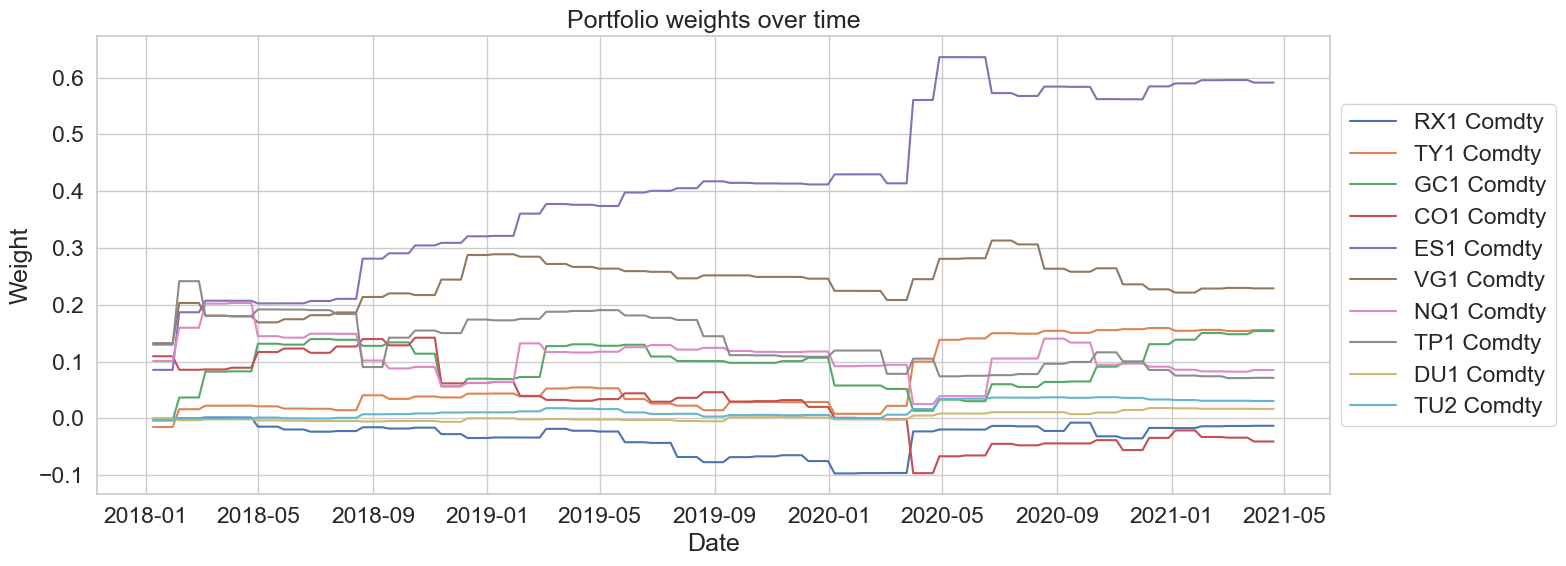

In [476]:
# Run the Kalman filter model
result_KF = rep.run_kalman_filter_model(
    rolling_window=208,               # 1 year rolling window
    rebalancing_window=4            # Weekly rebalancing
)

# Create a DataFrame for the results
result_KF_df = pd.DataFrame([result_KF])

# Display top configuration by information ratio
print("\nTop Optuna configuration by information ratio:")
display(result_KF_df[[ 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(1))

best_config_normalized_KF = result_KF_df.iloc[0]


# Create detailed metrics table for the best configuration
metrics_normalized_KF = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized_KF['target_return']*100:.2f}%",
               f"{best_config_normalized_KF['target_vol']*100:.2f}%",
               f"{best_config_normalized_KF['target_sharpe']:.2f}",
               f"{best_config_normalized_KF['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized_KF['replica_return']*100:.2f}%",
                f"{best_config_normalized_KF['replica_vol']*100:.2f}%",
                f"{best_config_normalized_KF['replica_sharpe']:.2f}",
                f"{best_config_normalized_KF['max_drawdown']*100:.2f}%",
                f"{best_config_normalized_KF['tracking_error']*100:.2f}%",
                f"{best_config_normalized_KF['information_ratio']:.2f}",
                f"{best_config_normalized_KF['correlation']:.4f}",
                f"{best_config_normalized_KF['avg_gross_exposure']:.4f}",
                f"{best_config_normalized_KF['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized_KF)


# Display the results
rep.plot_metrics(result_KF, 'Kalman Filter')

# EKF

In [477]:

name = get_selected_portfolio()
# the storage name wll be EN_PtfName and is in the foalder called with the name of the portfolio
folder_name = f"{name.replace(' ', '_')}"  # e.g., EN_Portfolio_Equity
storage_name = f"EKF_{name.replace(' ', '_')}"  # e.g., optuna_Portfolio_Equity
stu_name = f"EKF_{name.replace(' ', '_')}_study"  # e.g., Portfolio_Equity_study

storage_dir = Path.cwd() / folder_name
storage_dir.mkdir(parents=True, exist_ok=True)

storage_path = f"./{folder_name}/{storage_name}"

# 3) Run Optuna search
study_KFE = rep.run_optuna_normalized(
    n_trials=n_trials,
    storage=storage_path,
    study_name=stu_name,
    obj=rep._optuna_objective_KFE
)

[I 2025-05-30 01:43:38,502] Using an existing study with name 'EKF_Portfolio_Equity_study' instead of creating a new one.



Top Optuna configuration by information ratio:


,information_ratio,correlation,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
0,0.158869,0.975749,0.032825,0.907275,1.321488,0.066839



Detailed metrics for the best configuration (normalized returns):


,Metric,Target,Replica
0,Annualized return,13.08%,13.60%
1,Annualized volatility,14.69%,14.99%
2,Sharpe ratio,0.89,0.91
3,Max Drawdown,28.04%,27.06%
4,Tracking Error,N/A,3.28%
5,Information ratio,N/A,0.16
6,Correlation,N/A,0.9757
7,Average gross exposure,N/A,1.3215
8,"Average VaR (1%, 1M)",N/A,6.68%


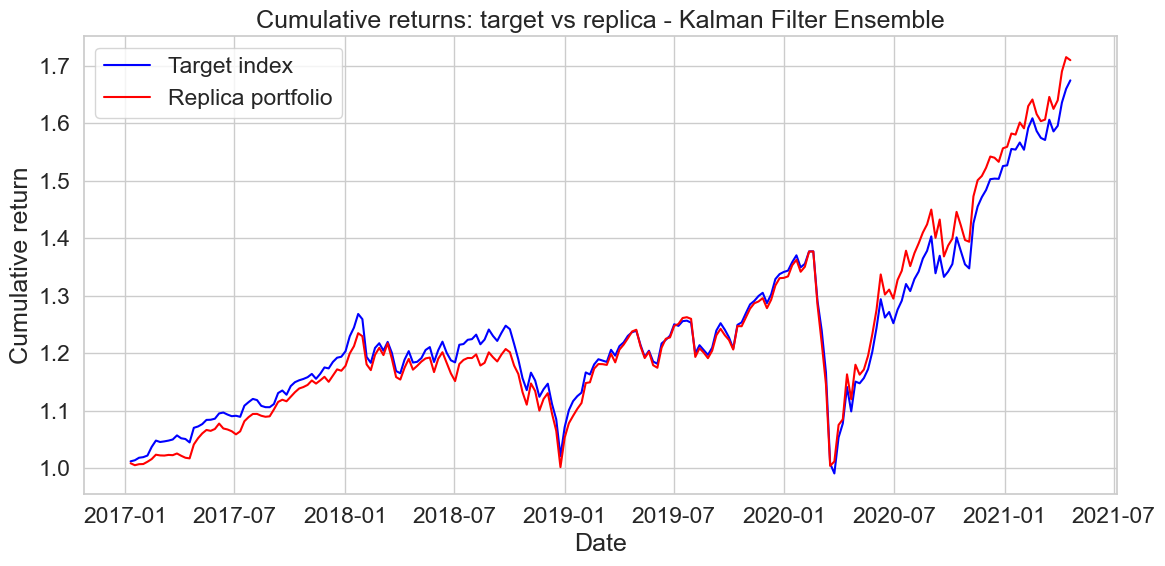

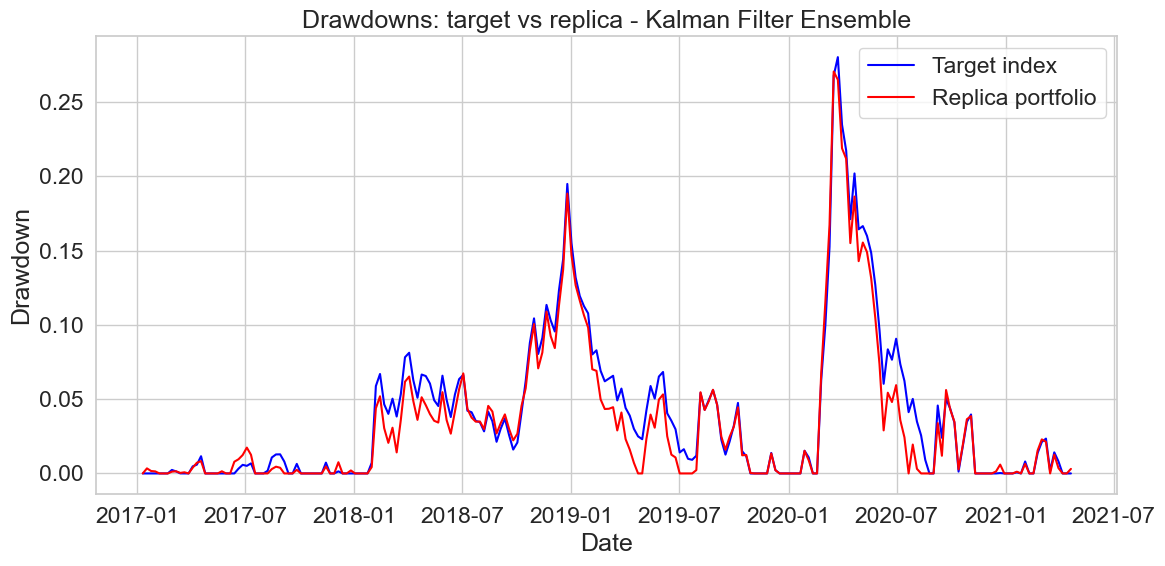

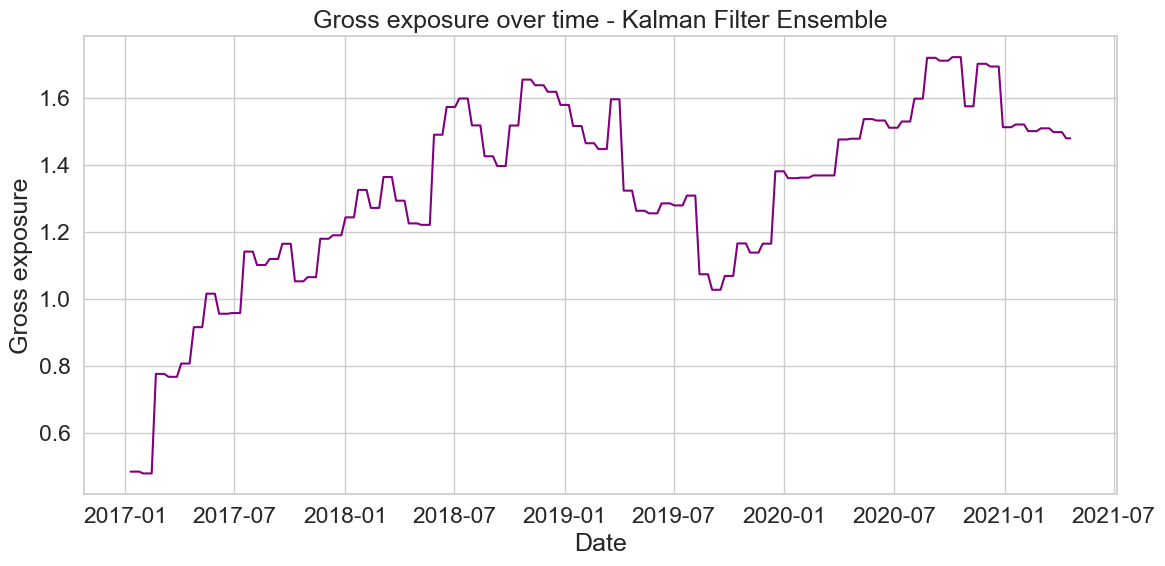

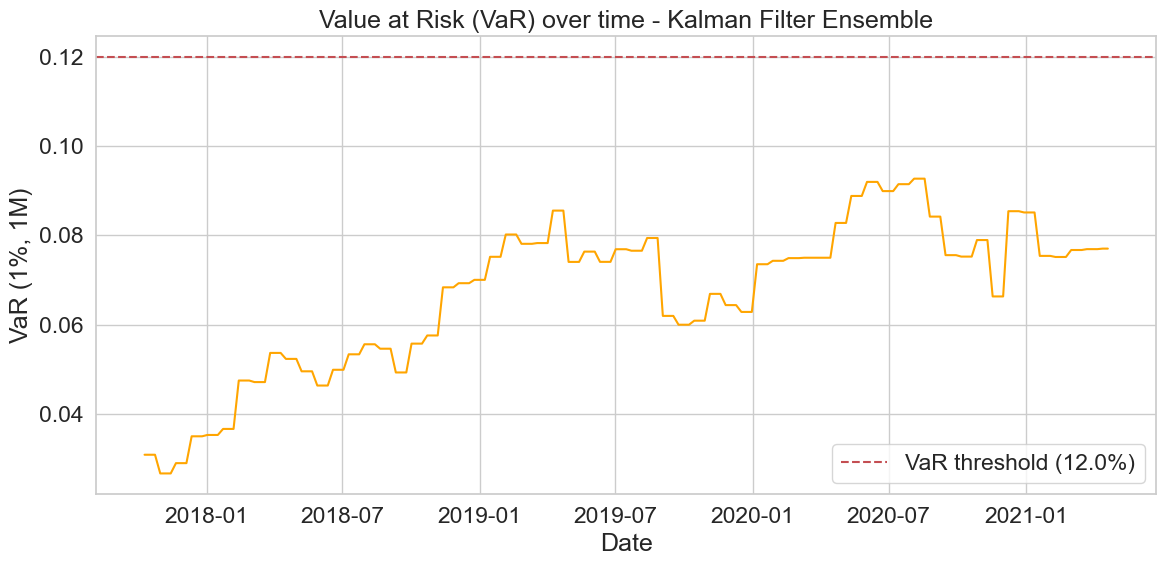

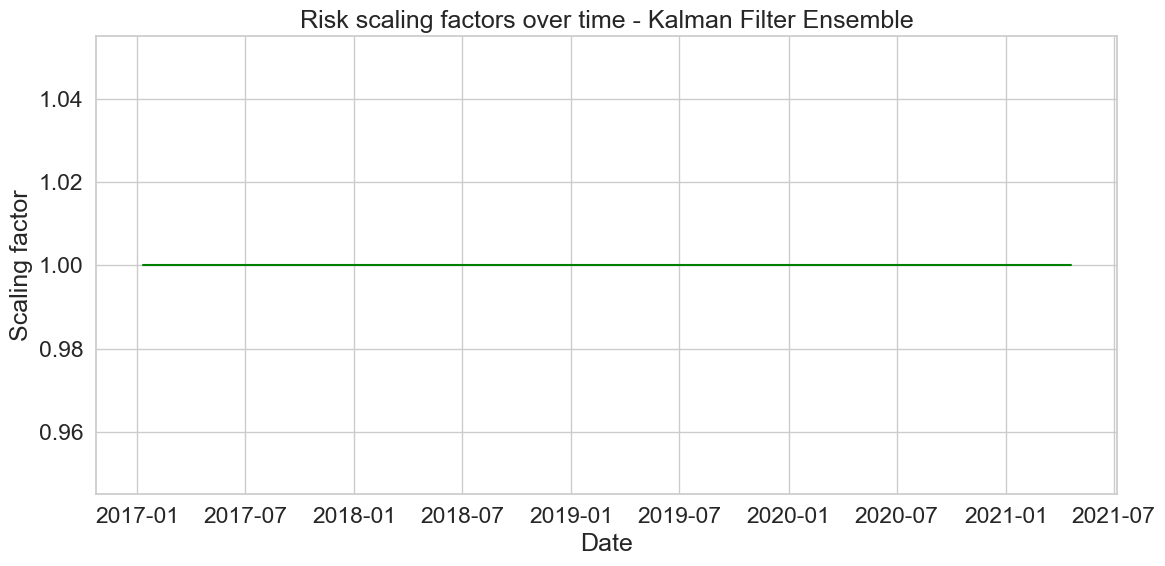

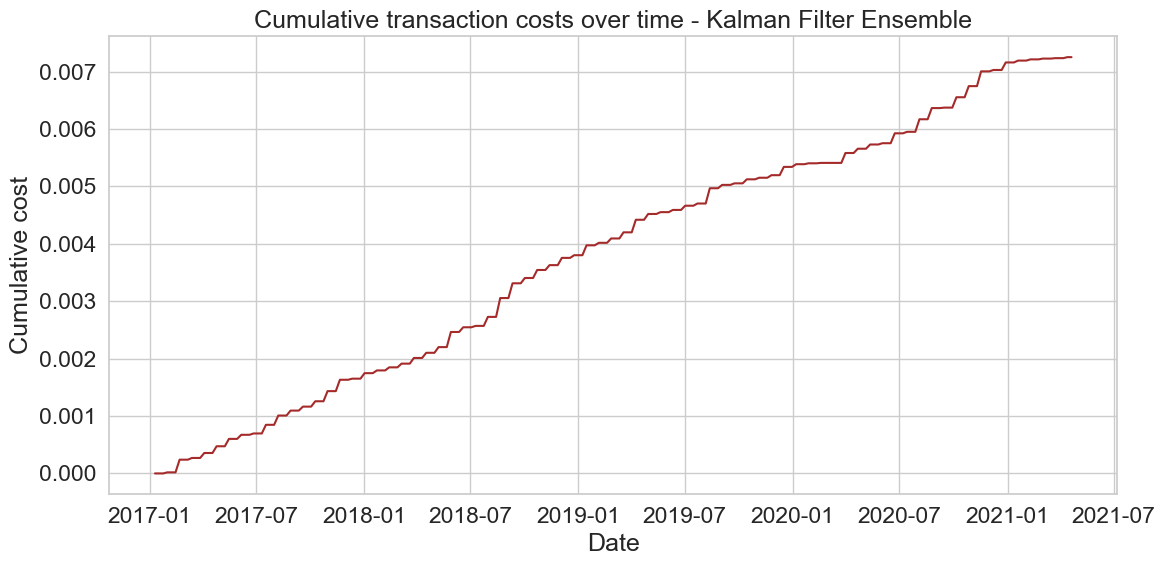

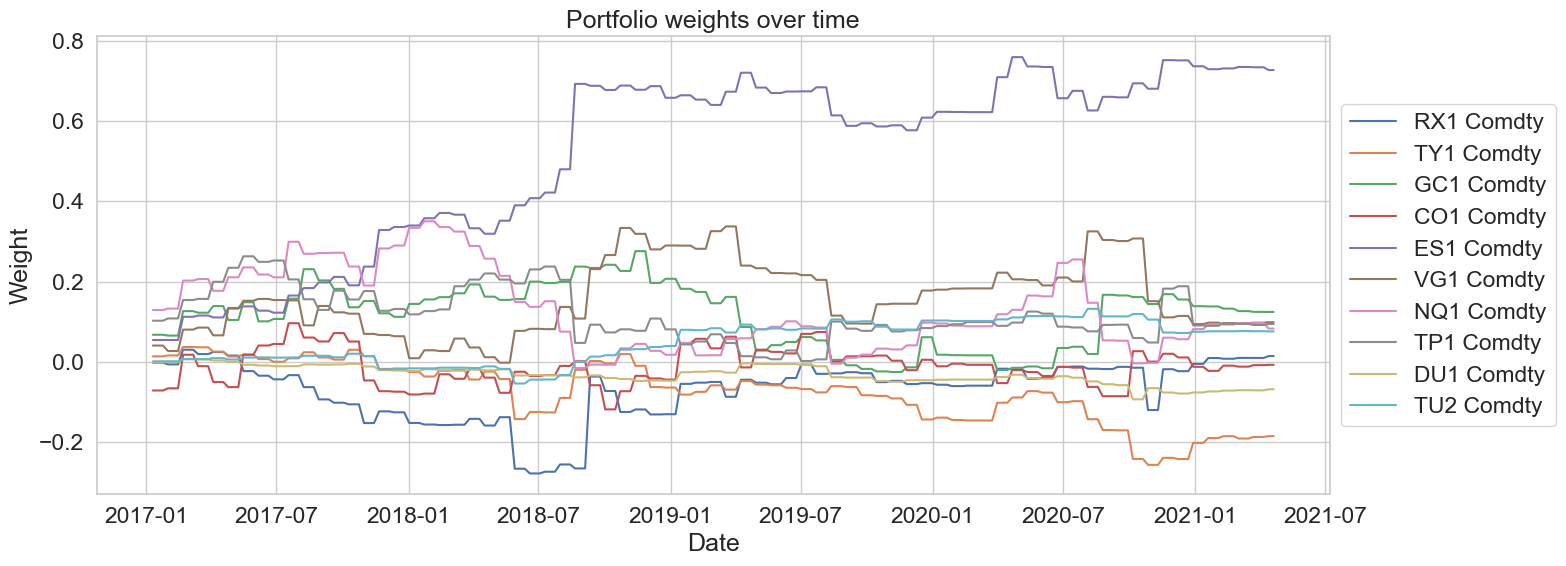

In [478]:
# # Import best parameters from optuna
ensemble_size = study_KFE.best_trial.params['ensemble_size']
process_noise_scale = study_KFE.best_trial.params['process_noise_scale']
rolling_window = study_KFE.best_trial.params['rolling_window']
rebalancing_window = study_KFE.best_trial.params['rebalancing_window']


# Run the Kalman filter model
result_KFE = rep.run_ensemble_kalman_filter_model(
    rolling_window=rolling_window,               
    rebalancing_window=rebalancing_window,       
    ensemble_size=ensemble_size,                 # Ensemble size from Optuna
    process_noise_scale=process_noise_scale      # Process noise scale from Optuna
)

# Create a DataFrame for the results
result_KFE_df = pd.DataFrame([result_KFE])

# Display top configuration by information ratio
print("\nTop Optuna configuration by information ratio:")
display(result_KFE_df[[ 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(1))

best_config_normalized_KFE = result_KFE_df.iloc[0]


# Create detailed metrics table for the best configuration
metrics_normalized_KFE = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized_KFE['target_return']*100:.2f}%",
               f"{best_config_normalized_KFE['target_vol']*100:.2f}%",
               f"{best_config_normalized_KFE['target_sharpe']:.2f}",
               f"{best_config_normalized_KFE['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized_KFE['replica_return']*100:.2f}%",
                f"{best_config_normalized_KFE['replica_vol']*100:.2f}%",
                f"{best_config_normalized_KFE['replica_sharpe']:.2f}",
                f"{best_config_normalized_KFE['max_drawdown']*100:.2f}%",
                f"{best_config_normalized_KFE['tracking_error']*100:.2f}%",
                f"{best_config_normalized_KFE['information_ratio']:.2f}",
                f"{best_config_normalized_KFE['correlation']:.4f}",
                f"{best_config_normalized_KFE['avg_gross_exposure']:.4f}",
                f"{best_config_normalized_KFE['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized_KFE)

# Plot the results for the best configuration
rep.plot_metrics(best_config_normalized_KFE, 'Kalman Filter Ensemble')

# ANALISI

In [479]:
# Build full comparison table
window=208

all_models_metrics = [
    rep.extract_target_metrics(window),
    rep.extract_replica_metrics(results_equal_weighted, 'Equally Weighted'),
    rep.extract_replica_metrics(results_df_normalized_EN.iloc[0].to_dict(), 'Elastic Net Normalized'),
    rep.extract_replica_metrics(best_config_normalized_KF.to_dict(), 'Kalman Filter'),
    rep.extract_replica_metrics(best_config_normalized_KFE.to_dict(), 'Ensemble Kalman Filter')
]

comparison_df = pd.DataFrame(all_models_metrics)

# Display
print("\nFull Performance Comparison (with consistent Target Portfolio metrics):")
display(comparison_df)



Full Performance Comparison (with consistent Target Portfolio metrics):


,Model,Annualized return,Annualized volatility,Sharpe ratio,Max Drawdown,Max Drawdown Value,Tracking Error,Information ratio,Correlation,Average gross exposure,"Average VaR (1%, 1M)",Transaction cost (bp)
0,Target Portfolio,11.39%,16.57%,0.69,28.04%,0.57,N/A,N/A,N/A,N/A,N/A,NaN
1,Equally Weighted,7.88%,10.63%,0.74,17.36%,NaN,9.63%,-0.36,0.8371,1.0000,N/A,50.00
2,Elastic Net Normalized,14.02%,13.17%,1.06,20.14%,NaN,4.99%,0.19,0.9417,0.8362,7.84%,27.33
3,Kalman Filter,10.55%,15.43%,0.68,22.88%,NaN,5.20%,-0.16,0.9497,1.1624,9.62%,23.36
4,Ensemble Kalman Filter,13.60%,14.99%,0.91,27.06%,NaN,3.28%,0.16,0.9757,1.3215,6.68%,72.54


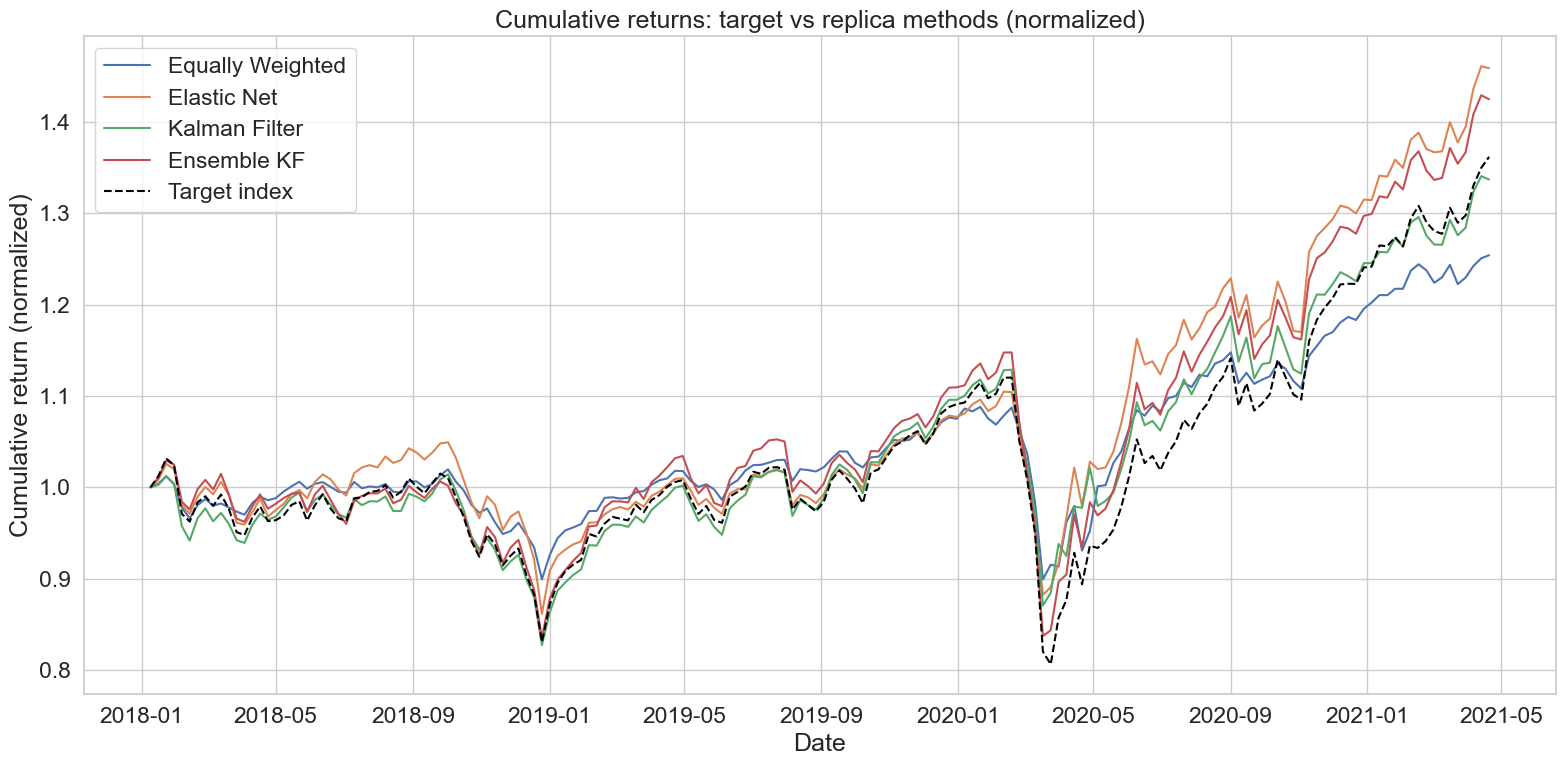

In [480]:
all_results = {
    'Equally Weighted' : results_equal_weighted,
    'Elastic Net'      : results_df_normalized_EN.iloc[0],
    'Kalman Filter'    : best_config_normalized_KF,
    'Ensemble KF'      : result_KFE
}
rep.plot_comparison(all_results)

# DISCRETE

In [481]:
# Portfolio value
portfolio_value = 10_000_000 
transaction_cost = 0.0005  # 0.05% transaction costs

Total transaction cost on the dataset: 41283.2596
Annualized average transaction cost: 9583.6138
Total Expense Ratio (TER) per annum: 0.0958%

Position History (first rows):


,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
2017-01-10,1,1,1,1,2146,1,501,396,1,1
2017-01-17,1,1,1,1,2147,1,501,406,1,1
2017-01-24,1,1,1,1,2113,1,508,397,1,1
2017-01-31,1,1,1,1,2113,1,506,395,1,1
2017-02-07,1,1,1,1,2093,1,508,386,1,1


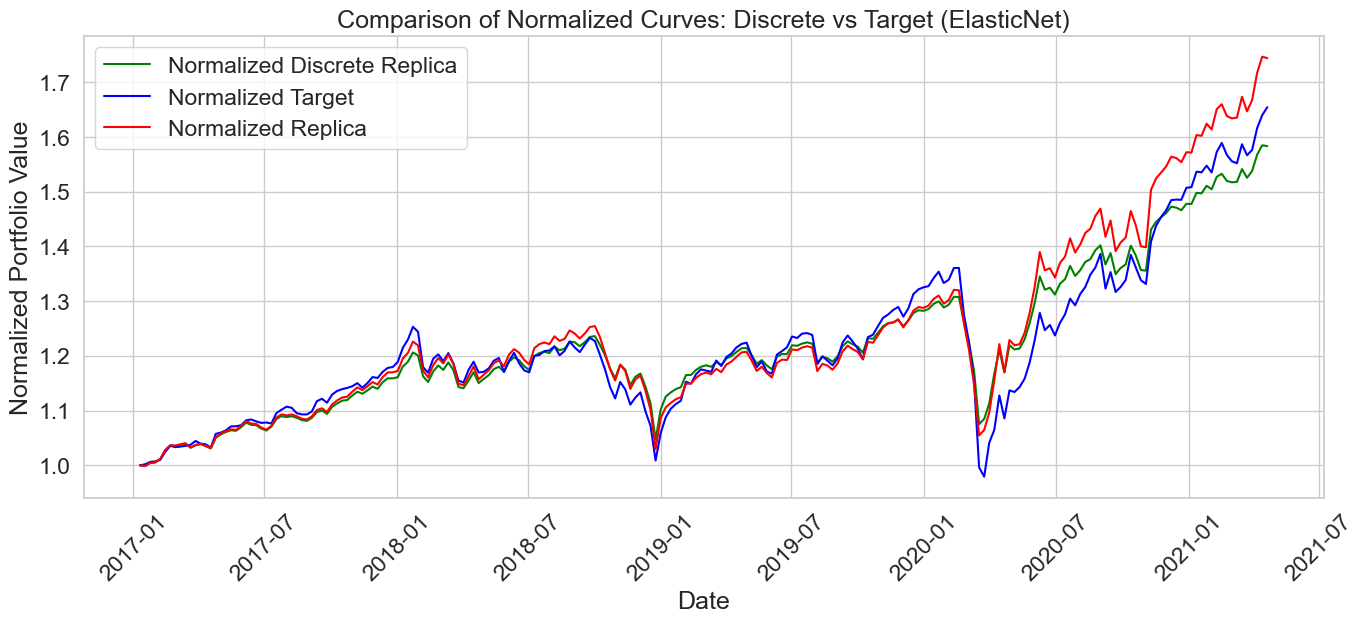

In [482]:
# ElasticNet Portfolio Allocation

total_cost_EN, annual_cost_EN, positions_history_df_EN = rep.compute_discrete_transaction_costs(
    result=results_EN,
    portfolio_value=portfolio_value,
    prices_df=df_underlyings,
    transaction_cost_rate=transaction_cost,
    rebalancing_freq=52
)

# Compute the TER (Total Expense Ratio) for the Elastic Net model per annum
TER_EN = annual_cost_EN / portfolio_value * 100  # in percentage

print("Total transaction cost on the dataset: {:.4f}".format(total_cost_EN))
print("Annualized average transaction cost: {:.4f}".format(annual_cost_EN))
print("Total Expense Ratio (TER) per annum: {:.4f}%".format(TER_EN))
print("\nPosition History (first rows):")
display(positions_history_df_EN.head())

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve = rep.compute_cumulative_equity_curve(positions_history_df_EN, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve = cumulative_equity_curve / cumulative_equity_curve.iloc[0]

# Retrieve the target curve from the model result
target_curve = results_EN['cumulative_target']

# If needed, the target can also be normalized (optional); for example:
normalized_target_curve = target_curve / target_curve.iloc[0]

# Retrive the replica curve with the optimized weights
replica_curve = results_EN['cumulative_replica']
normalized_replica_curve = replica_curve / replica_curve.iloc[0]

plt.figure(figsize=(16, 6))
plt.plot(normalized_discrete_curve.index, normalized_discrete_curve.values, label='Normalized Discrete Replica', color='green')
plt.plot(normalized_target_curve.index, normalized_target_curve.values, label='Normalized Target', color='blue')
plt.plot(normalized_replica_curve.index, normalized_replica_curve.values, label='Normalized Replica', color='red')

plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Comparison of Normalized Curves: Discrete vs Target (ElasticNet)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


Total transaction cost on the dataset: 40775.3599
Annualized average transaction cost: 12327.4344
Total Expense Ratio (TER) per annum: 0.1233%

Position History (first rows):


,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
2018-01-09,-21,-1216,-27,15920,312,367,152,689,2,-254
2018-01-16,-21,-1216,-27,15844,308,368,150,687,2,-255
2018-01-23,-21,-1222,-27,15660,302,363,146,680,2,-255
2018-01-30,-21,-1230,-27,15874,304,368,146,701,2,-255
2018-02-06,30,1342,279,12825,695,600,241,1396,-273,-5


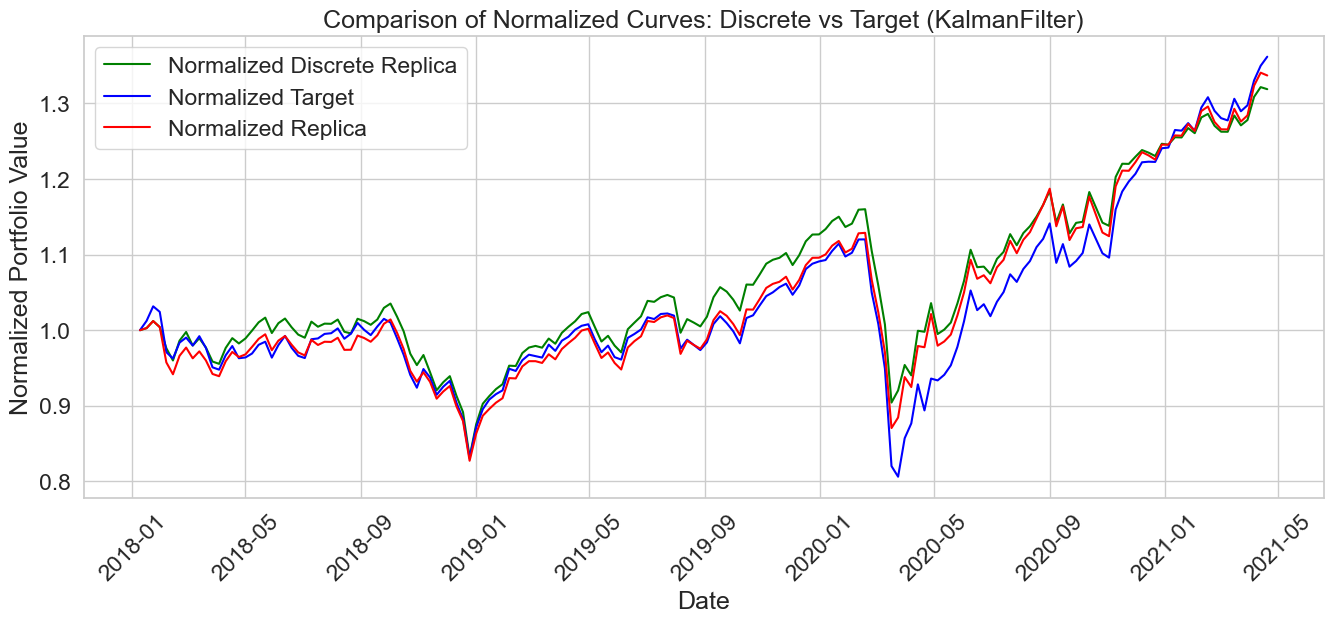

In [483]:
total_cost_KF, annual_cost_KF, positions_history_df_KF = rep.compute_discrete_transaction_costs(
    result=result_KF,
    portfolio_value=portfolio_value,
    prices_df=data[futures_contracts],
    transaction_cost_rate=transaction_cost,
    rebalancing_freq=52
)

# Compute the TER (Total Expense Ratio) for the Kalman Filter model per annum
TER_KF = annual_cost_KF / portfolio_value * 100  # in percentage

print("Total transaction cost on the dataset: {:.4f}".format(total_cost_KF))
print("Annualized average transaction cost: {:.4f}".format(annual_cost_KF))
print("Total Expense Ratio (TER) per annum: {:.4f}%".format(TER_KF))
print("\nPosition History (first rows):")
display(positions_history_df_KF.head())

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve = rep.compute_cumulative_equity_curve(positions_history_df_KF, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve = cumulative_equity_curve / cumulative_equity_curve.iloc[0]

# Retrieve the target curve from the model result
target_curve = result_KF['cumulative_target']

# If needed, the target can also be normalized (optional); for example:
normalized_target_curve = target_curve / target_curve.iloc[0]

# Retrive the replica curve with the optimized weights
replica_curve = result_KF['cumulative_replica']
normalized_replica_curve = replica_curve / replica_curve.iloc[0]

plt.figure(figsize=(16, 6))
plt.plot(normalized_discrete_curve.index, normalized_discrete_curve.values, label='Normalized Discrete Replica', color='green')
plt.plot(normalized_target_curve.index, normalized_target_curve.values, label='Normalized Target', color='blue')
plt.plot(normalized_replica_curve.index, normalized_replica_curve.values, label='Normalized Replica', color='red')

plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Comparison of Normalized Curves: Discrete vs Target (KalmanFilter)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Total transaction cost on the dataset: 90346.2246
Annualized average transaction cost: 20973.2307
Total Expense Ratio (TER) per annum: 0.2097%

Position History (first rows):


,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
2017-01-10,-109,1113,572,-13262,242,124,257,666,-72,140
2017-01-17,-109,1109,559,-12824,242,125,257,683,-72,140
2017-01-24,-109,1118,560,-12831,241,125,254,681,-72,141
2017-01-31,-382,1299,544,-11803,241,85,261,715,-27,156
2017-02-07,-379,1293,533,-11942,239,85,257,716,-27,156


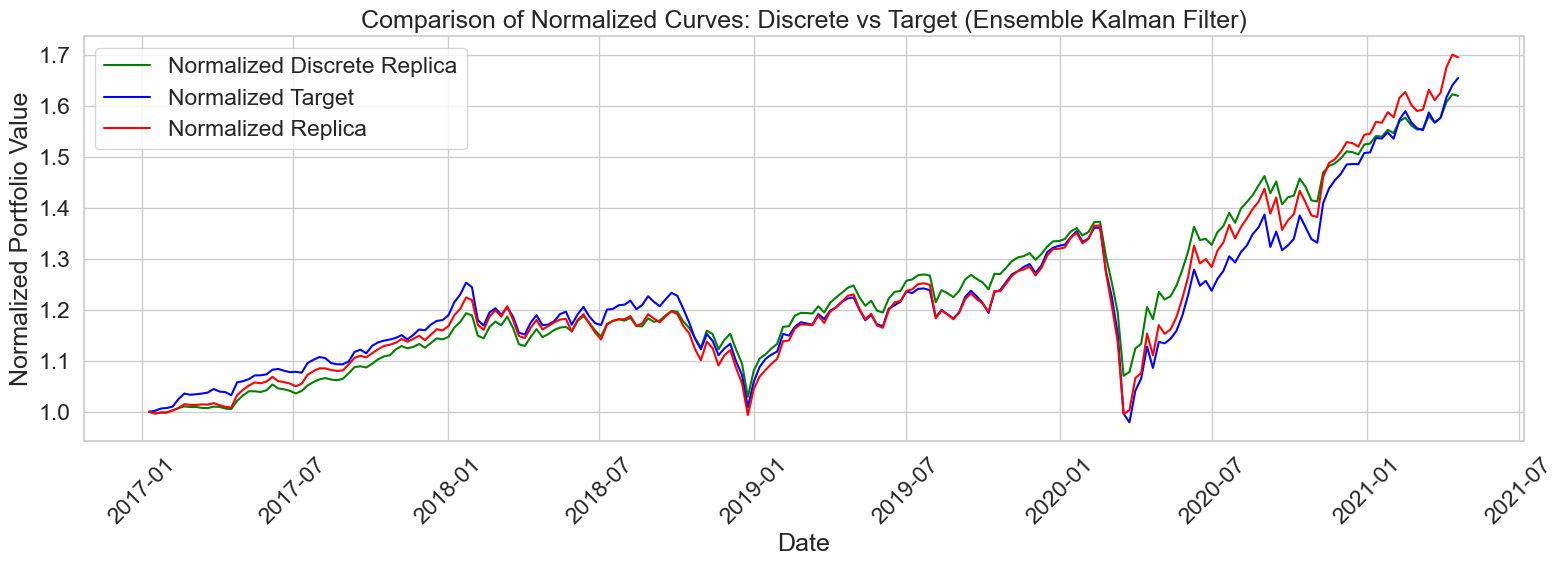

In [484]:
# Ensemble Kalman Filter Portfolio Allocation

total_cost_KFE, annual_cost_KFE, positions_history_df_KFE = rep.compute_discrete_transaction_costs(
    result=result_KFE,
    portfolio_value=portfolio_value,
    prices_df=data[futures_contracts],
    transaction_cost_rate=transaction_cost,
    rebalancing_freq=52
)

# Compute the TER (Total Expense Ratio) for the Ensemble Kalman Filter model per annum
TER_KFE = annual_cost_KFE / portfolio_value * 100  # in percentage

print("Total transaction cost on the dataset: {:.4f}".format(total_cost_KFE))
print("Annualized average transaction cost: {:.4f}".format(annual_cost_KFE))
print("Total Expense Ratio (TER) per annum: {:.4f}%".format(TER_KFE))
print("\nPosition History (first rows):")
display(positions_history_df_KFE.head())

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve = rep.compute_cumulative_equity_curve(positions_history_df_KFE, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve = cumulative_equity_curve / cumulative_equity_curve.iloc[0]

# Retrieve the target curve from the model result
target_curve = result_KFE['cumulative_target']

# If needed, the target can also be normalized (optional); for example:
normalized_target_curve = target_curve / target_curve.iloc[0]

# Retrive the replica curve with the optimized weights
replica_curve = result_KFE['cumulative_replica']
normalized_replica_curve = replica_curve / replica_curve.iloc[0]

plt.figure(figsize=(16, 6))
plt.plot(normalized_discrete_curve.index, normalized_discrete_curve.values, label='Normalized Discrete Replica', color='green')
plt.plot(normalized_target_curve.index, normalized_target_curve.values, label='Normalized Target', color='blue')
plt.plot(normalized_replica_curve.index, normalized_replica_curve.values, label='Normalized Replica', color='red')
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Comparison of Normalized Curves: Discrete vs Target (Ensemble Kalman Filter)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Alternative Ptfs

In [485]:
# carica datadset detection -> anomalyDetectionDataset.csv and set data as index
detection_data = pd.read_csv('anomalyDetectionDataset.csv', index_col='Data', parse_dates=True)

# aggiornare i pesi levando il caso in cui detection = 1

# ricalcola curva e metriche

In [486]:
# detection_data = pd.read_excel('Dataset4_EWS.xlsx', index_col='Data', parse_dates=True, sheet_name='Markets')
# detection_data = detection_data['Y']
# detection_data = pd.DataFrame(detection_data, columns=['Y'])

In [487]:
detection_data
positions_history_df_KFE.index[0]
detection_data = detection_data[detection_data.index >= positions_history_df_KFE.index[0]]

In [488]:
# change psotition history when detection is 1, all weights are set to 0
positions_history_df_KFE_Alternative = positions_history_df_KFE.copy()
positions_history_df_KFE_Alternative_gg = pd.DataFrame(result_KFE['weights_history']).copy()
# # set the index
positions_history_df_KFE_Alternative_gg.index = positions_history_df_KFE_Alternative.index

# Set weights to 0 where detection is 1
positions_history_df_KFE_Alternative.loc[detection_data[detection_data['y_pred'] == 1].index] = 0

In [489]:
# the clumns names og positions_history_df_KFE_Alternative_gg are the same as positions_history_df_KFE_Alternative
positions_history_df_KFE_Alternative_gg.columns = positions_history_df_KFE_Alternative.columns
positions_history_df_KFE_Alternative_gg

,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
2017-01-10,-0.001787,0.013883,0.067763,-0.071139,0.054694,0.040780,0.129303,0.102748,-0.000814,0.001514
2017-01-17,-0.001787,0.013883,0.067763,-0.071139,0.054694,0.040780,0.129303,0.102748,-0.000814,0.001514
2017-01-24,-0.001787,0.013883,0.067763,-0.071139,0.054694,0.040780,0.129303,0.102748,-0.000814,0.001514
2017-01-31,-0.006194,0.016167,0.065661,-0.065745,0.054686,0.027213,0.132950,0.108380,-0.000306,0.001677
2017-02-07,-0.006194,0.016167,0.065661,-0.065745,0.054686,0.027213,0.132950,0.108380,-0.000306,0.001677
...,...,...,...,...,...,...,...,...,...,...
2021-03-23,0.009941,-0.186889,0.124815,-0.007995,0.734412,0.097836,0.096799,0.092130,-0.070803,0.076570
2021-03-30,0.009941,-0.186889,0.124815,-0.007995,0.734412,0.097836,0.096799,0.092130,-0.070803,0.076570
2021-04-06,0.009941,-0.186889,0.124815,-0.007995,0.734412,0.097836,0.096799,0.092130,-0.070803,0.076570
2021-04-13,0.014636,-0.184827,0.124581,-0.007200,0.727389,0.098999,0.083158,0.094567,-0.068156,0.076085


In [490]:
positions_history_df_KFE_Alternative_gg

,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
2017-01-10,-0.001787,0.013883,0.067763,-0.071139,0.054694,0.040780,0.129303,0.102748,-0.000814,0.001514
2017-01-17,-0.001787,0.013883,0.067763,-0.071139,0.054694,0.040780,0.129303,0.102748,-0.000814,0.001514
2017-01-24,-0.001787,0.013883,0.067763,-0.071139,0.054694,0.040780,0.129303,0.102748,-0.000814,0.001514
2017-01-31,-0.006194,0.016167,0.065661,-0.065745,0.054686,0.027213,0.132950,0.108380,-0.000306,0.001677
2017-02-07,-0.006194,0.016167,0.065661,-0.065745,0.054686,0.027213,0.132950,0.108380,-0.000306,0.001677
...,...,...,...,...,...,...,...,...,...,...
2021-03-23,0.009941,-0.186889,0.124815,-0.007995,0.734412,0.097836,0.096799,0.092130,-0.070803,0.076570
2021-03-30,0.009941,-0.186889,0.124815,-0.007995,0.734412,0.097836,0.096799,0.092130,-0.070803,0.076570
2021-04-06,0.009941,-0.186889,0.124815,-0.007995,0.734412,0.097836,0.096799,0.092130,-0.070803,0.076570
2021-04-13,0.014636,-0.184827,0.124581,-0.007200,0.727389,0.098999,0.083158,0.094567,-0.068156,0.076085


In [491]:
positions_history_df_KFE

,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
2017-01-10,-109,1113,572,-13262,242,124,257,666,-72,140
2017-01-17,-109,1109,559,-12824,242,125,257,683,-72,140
2017-01-24,-109,1118,560,-12831,241,125,254,681,-72,141
2017-01-31,-382,1299,544,-11803,241,85,261,715,-27,156
2017-02-07,-379,1293,533,-11942,239,85,257,716,-27,156
...,...,...,...,...,...,...,...,...,...,...
2021-03-23,579,-14166,724,-1315,1884,260,75,471,-6313,6937
2021-03-30,582,-14245,742,-1246,1861,253,76,466,-6316,6937
2021-04-06,580,-14191,717,-1274,1808,250,72,472,-6314,6944
2021-04-13,855,-13993,714,-1130,1761,253,60,483,-6079,6899


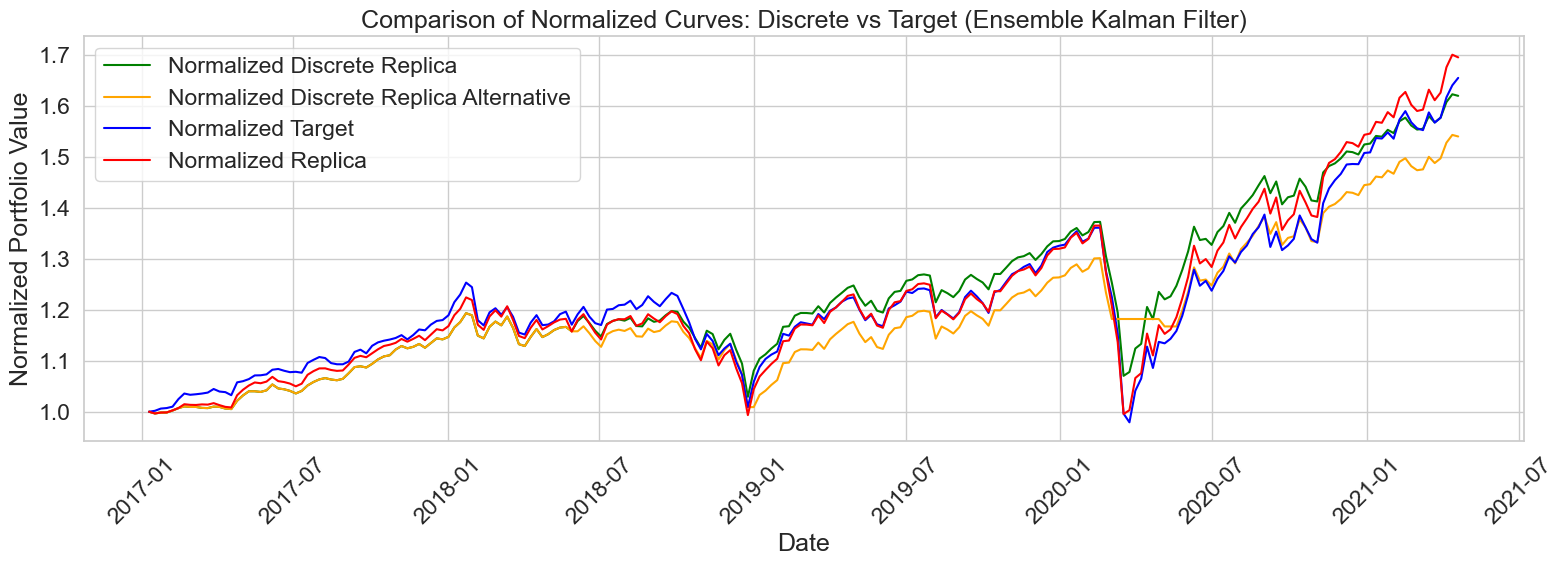

In [492]:
# Ensemble Kalman Filter Portfolio Allocation

# total_cost_KFE, annual_cost_KFE, positions_history_df_KFE = rep.compute_discrete_transaction_costs(
#     result=result_KFE_Alternative,
#     portfolio_value=portfolio_value,
#     prices_df=data[futures_contracts],
#     transaction_cost_rate=transaction_cost,
#     rebalancing_freq=52
# )

# # Compute the TER (Total Expense Ratio) for the Ensemble Kalman Filter model per annum
# TER_KFE = annual_cost_KFE / portfolio_value * 100  # in percentage

# print("Total transaction cost on the dataset: {:.4f}".format(total_cost_KFE))
# print("Annualized average transaction cost: {:.4f}".format(annual_cost_KFE))
# print("Total Expense Ratio (TER) per annum: {:.4f}%".format(TER_KFE))
# print("\nPosition History (first rows):")
# display(positions_history_df_KFE.head())

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve = rep.compute_cumulative_equity_curve(positions_history_df_KFE, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve = cumulative_equity_curve / cumulative_equity_curve.iloc[0]

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve_alt = rep.compute_cumulative_equity_curve(positions_history_df_KFE_Alternative, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve_alt = cumulative_equity_curve_alt / cumulative_equity_curve_alt.iloc[0]

# Retrieve the target curve from the model result
target_curve = result_KFE['cumulative_target']

# If needed, the target can also be normalized (optional); for example:
normalized_target_curve = target_curve / target_curve.iloc[0]

# Retrive the replica curve with the optimized weights
replica_curve = result_KFE['cumulative_replica']
normalized_replica_curve = replica_curve / replica_curve.iloc[0]

plt.figure(figsize=(16, 6))
plt.plot(normalized_discrete_curve.index, normalized_discrete_curve.values, label='Normalized Discrete Replica', color='green')
plt.plot(normalized_discrete_curve_alt.index, normalized_discrete_curve_alt.values, label='Normalized Discrete Replica Alternative', color='orange')
plt.plot(normalized_target_curve.index, normalized_target_curve.values, label='Normalized Target', color='blue')
plt.plot(normalized_replica_curve.index, normalized_replica_curve.values, label='Normalized Replica', color='red')
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Comparison of Normalized Curves: Discrete vs Target (Ensemble Kalman Filter)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
